In [1]:
def prepare_dataset(filepath):
    dataset_raw = np.load(filepath, allow_pickle=True).item()

    HR_list, RESP_list, ACC_CHEST_list, ACC_WRIST_list, ACTIVITY_list, TIME_list = [], [], [], [], [], []
    TEMP_AVG_list, TEMP_GRAD_list = [], []
    TRAITS_list = []

    for subject_data in dataset_raw.values():
        signals = subject_data['signal']
        info = subject_data['info']

        # Handle Gender conversion
        gender = info.get('Gender', 'm')
        if isinstance(gender, str):
            gender = 1.0 if gender.lower().strip() in ['f', 'female'] else 0.0
        else:
            gender = float(gender)

        # Handle SPORT conversion (you can improve this with specific mappings)
        sport = info.get('SPORT', 0)
        if isinstance(sport, str):
            sport = 1.0  # or use mappings if different categories exist
        else:
            sport = float(sport)

        traits = np.array([
            float(info.get('HEIGHT', 170)),
            float(info.get('WEIGHT', 70)),
            float(info.get('AGE', 30)),
            gender,
            sport
        ])

        HR_list.append(signals['hr'])
        RESP_list.append(signals['resp'])
        ACC_CHEST_list.append(signals['acc_chest'])
        ACC_WRIST_list.append(signals['acc_wrist'])
        ACTIVITY_list.append(signals['activity'])
        TIME_list.append(signals['time'])
        TEMP_AVG_list.append(signals['temp_avg'])
        TEMP_GRAD_list.append(signals['temp_grad'])
        TRAITS_list.append(np.tile(traits, (len(signals['hr']), 1)))

    dataset_processed = {
        "HR": np.concatenate(HR_list),
        "RESP": np.concatenate(RESP_list),
        "ACC_CHEST": np.concatenate(ACC_CHEST_list),
        "ACC_WRIST": np.concatenate(ACC_WRIST_list),
        "ACTIVITY": np.concatenate(ACTIVITY_list),
        "TIME": np.concatenate(TIME_list),
        "TEMP_AVG": np.concatenate(TEMP_AVG_list),
        "TEMP_GRAD": np.concatenate(TEMP_GRAD_list),
        "TRAITS": np.concatenate(TRAITS_list)
    }

    return dataset_processed


In [2]:
import gymnasium as gym
from gymnasium import spaces

class HRPredictionEnv(gym.Env):
    
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

        self.signal_dim = 8
        self.signal_len = 60
        self.pred_len = 10
        self.trait_dim = 5
        self.length = 60

        self.observation_space = spaces.Dict({
            "signals": spaces.Box(low=-np.inf, high=np.inf, shape=(self.signal_dim, self.signal_len), dtype=np.float32),
            "traits": spaces.Box(low=0, high=1e3, shape=(self.trait_dim,), dtype=np.float32)
        })

        self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(self.pred_len,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = np.random.randint(0, len(self.dataset["HR"]) - 70)

        self.traits = self.dataset["TRAITS"][self.index]
        self.true_hr_targets = self.dataset["HR"][self.index + 60 : self.index + 70]

        
    # NaN check BEFORE stacking:
        channels = {
        "HR": self.dataset["HR"][self.index : self.index + self.length],
        "RESP": self.dataset["RESP"][self.index : self.index + self.length],
        "ACC_CHEST": self.dataset["ACC_CHEST"][self.index : self.index + self.length],
        "ACC_WRIST": self.dataset["ACC_WRIST"][self.index : self.index + self.length],
        "ACTIVITY": self.dataset["ACTIVITY"][self.index : self.index + self.length],
        "TIME": self.dataset["TIME"][self.index : self.index + self.length],
        "TEMP_AVG": self.dataset["TEMP_AVG"][self.index : self.index + self.length],
        "TEMP_GRAD": self.dataset["TEMP_GRAD"][self.index : self.index + self.length],
    }

        for name, data in channels.items():
            if np.isnan(data).any():
                print(f"NaNs detected in channel: {name} at reset (index {self.index})")

        signal_matrix = np.stack(list(channels.values()))

    # Sanitize the stacked matrix:
        signal_matrix = np.nan_to_num(signal_matrix, nan=0.0, posinf=0.0, neginf=0.0)

        obs = {
        "signals": signal_matrix.astype(np.float32),
        "traits": np.nan_to_num(self.traits.astype(np.float32), nan=0.0)
    }

        if np.isnan(self.traits).any():
            print("NaNs detected in traits at reset (index {}).".format(self.index))

        return obs, {}


    def step(self, action):
        gt_hr = self.true_hr_targets
        predicted_hr = self.dataset["HR"][self.index + self.length] + action
        #predicted_hr = self.dataset["HR"][self.index + 120 : self.index + 130] + action  # shape (10,)

        mse = np.mean((predicted_hr - gt_hr) ** 2)
        reward = -mse

        terminated = True
        truncated = False

        obs = {
            "signals": np.stack([
                self.dataset["HR"][self.index : self.index + self.length],
                self.dataset["RESP"][self.index : self.index + self.length],
                self.dataset["ACC_CHEST"][self.index : self.index + self.length],
                self.dataset["ACC_WRIST"][self.index : self.index + self.length],
                self.dataset["ACTIVITY"][self.index : self.index + self.length],
                self.dataset["TIME"][self.index : self.index + self.length],
                self.dataset["TEMP_AVG"][self.index : self.index + self.length],
                self.dataset["TEMP_GRAD"][self.index : self.index + self.length]
            ]).astype(np.float32),
            "traits": self.traits.astype(np.float32)
        }

        info = {
            "true_hr": gt_hr,
            "predicted_hr": predicted_hr,
            "prediction_error": mse
        }

        return obs, reward, terminated, truncated, info


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

class ActorCritic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU()
        )
        self.actor_mean = nn.Linear(128, action_dim)
        self.actor_log_std = nn.Parameter(torch.ones(action_dim) * -0.5)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        mean = self.actor_mean(x)
        std = torch.exp(self.actor_log_std).clamp(1e-3, 2.0)  # clamp to avoid extreme values
        value = self.critic(x)
        return mean, std, value
class PPOAgent:
    def __init__(self, obs_dim, action_dim, lr=3e-4, gamma=0.99, clip=0.2, device='cuda'):
        self.model = ActorCritic(obs_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.clip = clip
        self.device = device

    def select_action(self, obs):
        obs = torch.FloatTensor(obs).flatten().to(self.device)

        obs = (obs - obs.mean()) / (obs.std() + 1e-8)

        if torch.isnan(obs).any() or torch.isinf(obs).any():
            print("Found NaN or Inf in observations:", obs)
        
        mean, std, _ = self.model(obs)
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        return action.detach().cpu().numpy(), log_prob.detach()

    def compute_returns(self, rewards, dones):
        returns = []
        G = 0
        for r, done in zip(reversed(rewards), reversed(dones)):
            if done:
                G = 0
            G = r + self.gamma * G
            returns.insert(0, G)
        return torch.tensor(returns, dtype=torch.float32).to(self.device)

    def update(self, obs, actions, log_probs, returns):
        obs = torch.FloatTensor(obs).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        old_log_probs = torch.stack(log_probs).to(self.device)

        mean, std, values = self.model(obs)
        dist = Normal(mean, std)
        new_log_probs = dist.log_prob(actions).sum(axis=1)
        advantages = returns - values.squeeze()

        ratio = (new_log_probs - old_log_probs).exp()
        clipped = torch.clamp(ratio, 1 - self.clip, 1 + self.clip) * advantages
        loss = -torch.min(ratio * advantages, clipped).mean() + nn.functional.mse_loss(values.squeeze(), returns)

        self.optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
        
        self.optimizer.step()
        return loss.item()


In [4]:
from tqdm import trange

dataset = prepare_dataset('/kaggle/input/finaldata/Data_final.npy')



def split_dataset(dataset, train_ratio=0.8):
    total_length = len(dataset["HR"])
    split_index = int(total_length * train_ratio)

    train_data = {k: v[:split_index] for k, v in dataset.items()}
    test_data = {k: v[split_index:] for k, v in dataset.items()}

    return train_data, test_data

# Example usage:
train_dataset, test_dataset = split_dataset(dataset)






env = HRPredictionEnv(train_dataset)
obs_dim = 8 * 60 + 5  # 8 signals x 120 + 5 traits
action_dim = 10
agent = PPOAgent(obs_dim, action_dim, device='cuda' if torch.cuda.is_available() else 'cpu')

reward_history = []
loss_history = []

all_predicted_hr = []
all_true_hr = []

def train(num_episodes=1000, batch_size=32):
    for episode in trange(num_episodes):
        batch_obs, batch_actions, batch_log_probs, batch_rewards, batch_dones = [], [], [], [], []

        for _ in range(batch_size):
            obs, _ = env.reset()
            flat_obs = np.concatenate([obs['signals'].flatten(), obs['traits'].flatten()])
            action, log_prob = agent.select_action(flat_obs)
            next_obs, reward, done, _, info = env.step(action)

            all_predicted_hr.append(info["predicted_hr"])
            all_true_hr.append(info["true_hr"])

            batch_obs.append(flat_obs)
            batch_actions.append(action)
            batch_log_probs.append(log_prob)
            batch_rewards.append(reward)
            batch_dones.append(done)

        returns = agent.compute_returns(batch_rewards, batch_dones)

        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        loss = agent.update(batch_obs, batch_actions, batch_log_probs, returns)

        print(f"Episode {episode}: Avg Reward={np.mean(batch_rewards):.3f}, Loss={loss:.4f}")

        reward_history.append(reward)
        loss_history.append(loss)

        if episode % 50 == 0:
            torch.save(agent.model.state_dict(), f'ppo_checkpoint_{episode}.pt')

train()


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_36/2818179151.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  obs = torch.FloatTensor(obs).to(self.device)
  0%|          | 4/1000 [00:00<00:56, 17.69it/s]

Episode 0: Avg Reward=-20.757, Loss=1413.7266
Episode 1: Avg Reward=-10.971, Loss=21760.4805
Episode 2: Avg Reward=-10.662, Loss=15784.1348
Episode 3: Avg Reward=-22.156, Loss=1834.1858
Episode 4: Avg Reward=-19.588, Loss=5388.3018
Episode 5: Avg Reward=-10.372, Loss=11542.7236


  1%|          | 10/1000 [00:00<00:42, 23.30it/s]

Episode 6: Avg Reward=-8.745, Loss=6353.2739
Episode 7: Avg Reward=-18.690, Loss=2012.3752
Episode 8: Avg Reward=-9.392, Loss=406.8374
Episode 9: Avg Reward=-17.120, Loss=1997.2909
Episode 10: Avg Reward=-16.987, Loss=1682.9476
Episode 11: Avg Reward=-18.356, Loss=38.9432


  2%|▏         | 16/1000 [00:00<00:38, 25.36it/s]

Episode 12: Avg Reward=-20.648, Loss=2314.0876
Episode 13: Avg Reward=-18.479, Loss=4269.6899
Episode 14: Avg Reward=-8.833, Loss=3597.0466
Episode 15: Avg Reward=-24.669, Loss=738.7472
Episode 16: Avg Reward=-21.487, Loss=671.3654
Episode 17: Avg Reward=-16.790, Loss=1742.2341


  2%|▏         | 22/1000 [00:00<00:37, 25.95it/s]

Episode 18: Avg Reward=-15.522, Loss=1102.4851
Episode 19: Avg Reward=-10.983, Loss=2.7800
Episode 20: Avg Reward=-18.297, Loss=1968.6473
Episode 21: Avg Reward=-25.584, Loss=3488.6016
Episode 22: Avg Reward=-27.918, Loss=2742.2656
Episode 23: Avg Reward=-25.438, Loss=955.9497


  3%|▎         | 28/1000 [00:01<00:37, 26.03it/s]

Episode 24: Avg Reward=-21.106, Loss=995.3627
Episode 25: Avg Reward=-19.308, Loss=820.4861
Episode 26: Avg Reward=-17.425, Loss=618.0302
Episode 27: Avg Reward=-10.581, Loss=4.2386
Episode 28: Avg Reward=-17.521, Loss=1203.6993
Episode 29: Avg Reward=-17.652, Loss=2456.9067


  3%|▎         | 34/1000 [00:01<00:37, 26.06it/s]

Episode 30: Avg Reward=-15.778, Loss=2096.0686
Episode 31: Avg Reward=-13.686, Loss=628.5519
Episode 32: Avg Reward=-16.455, Loss=134.4187
Episode 33: Avg Reward=-12.026, Loss=551.1732
Episode 34: Avg Reward=-18.083, Loss=548.9745
Episode 35: Avg Reward=-13.324, Loss=8.8894


  4%|▍         | 40/1000 [00:01<00:36, 26.16it/s]

Episode 36: Avg Reward=-18.828, Loss=1700.4292
Episode 37: Avg Reward=-21.186, Loss=2439.8342
Episode 38: Avg Reward=-8.042, Loss=2184.2625
Episode 39: Avg Reward=-15.063, Loss=513.9953
Episode 40: Avg Reward=-15.205, Loss=85.5103
Episode 41: Avg Reward=-16.282, Loss=434.7380


  5%|▍         | 46/1000 [00:01<00:37, 25.51it/s]

Episode 42: Avg Reward=-17.681, Loss=393.0526
Episode 43: Avg Reward=-15.975, Loss=1.4140
Episode 44: Avg Reward=-17.188, Loss=3.7132
Episode 45: Avg Reward=-12.747, Loss=248.0096
Episode 46: Avg Reward=-10.488, Loss=320.1245
Episode 47: Avg Reward=-12.150, Loss=62.6043


  5%|▌         | 52/1000 [00:02<00:37, 25.45it/s]

Episode 48: Avg Reward=-13.215, Loss=66.1629
Episode 49: Avg Reward=-12.663, Loss=92.7561
Episode 50: Avg Reward=-15.039, Loss=33.5564
Episode 51: Avg Reward=-27.494, Loss=104.5410
Episode 52: Avg Reward=-8.825, Loss=146.3188
Episode 53: Avg Reward=-16.989, Loss=24.6614


  6%|▌         | 58/1000 [00:02<00:36, 25.93it/s]

Episode 54: Avg Reward=-12.047, Loss=12.5570
Episode 55: Avg Reward=-21.518, Loss=167.2263
Episode 56: Avg Reward=-16.354, Loss=164.6756
Episode 57: Avg Reward=-16.042, Loss=145.2382
Episode 58: Avg Reward=-15.703, Loss=8.1997
Episode 59: Avg Reward=-11.403, Loss=283.2332


  6%|▋         | 64/1000 [00:02<00:35, 26.46it/s]

Episode 60: Avg Reward=-29.686, Loss=218.9602
Episode 61: Avg Reward=-20.246, Loss=6.0683
Episode 62: Avg Reward=-16.422, Loss=1.7201
Episode 63: Avg Reward=-15.869, Loss=241.0250
Episode 64: Avg Reward=-17.405, Loss=251.9013
Episode 65: Avg Reward=-15.778, Loss=2.1815


  7%|▋         | 70/1000 [00:02<00:35, 26.15it/s]

Episode 66: Avg Reward=-9.938, Loss=814.6177
Episode 67: Avg Reward=-16.356, Loss=1418.8392
Episode 68: Avg Reward=-10.423, Loss=1509.9104
Episode 69: Avg Reward=-11.387, Loss=189.6038
Episode 70: Avg Reward=-11.064, Loss=380.6642
Episode 71: Avg Reward=-20.593, Loss=1298.2684


  8%|▊         | 76/1000 [00:03<00:35, 25.99it/s]

Episode 72: Avg Reward=-13.546, Loss=1191.6567
Episode 73: Avg Reward=-14.721, Loss=225.7229
Episode 74: Avg Reward=-18.929, Loss=161.9302
Episode 75: Avg Reward=-12.998, Loss=705.1921
Episode 76: Avg Reward=-12.334, Loss=403.4252
Episode 77: Avg Reward=-16.801, Loss=138.4621


  8%|▊         | 82/1000 [00:03<00:37, 24.33it/s]

Episode 78: Avg Reward=-14.870, Loss=765.4009
Episode 79: Avg Reward=-9.850, Loss=1222.8439
Episode 80: Avg Reward=-18.867, Loss=1051.8483
Episode 81: Avg Reward=-46.450, Loss=730.7184
Episode 82: Avg Reward=-20.377, Loss=598.8420


  9%|▉         | 88/1000 [00:03<00:36, 24.79it/s]

Episode 83: Avg Reward=-13.634, Loss=658.6133
Episode 84: Avg Reward=-6.593, Loss=787.5627
Episode 85: Avg Reward=-14.742, Loss=124.9044
Episode 86: Avg Reward=-15.223, Loss=451.7823
Episode 87: Avg Reward=-14.430, Loss=945.0856
Episode 88: Avg Reward=-10.406, Loss=817.1295


  9%|▉         | 94/1000 [00:03<00:35, 25.69it/s]

Episode 89: Avg Reward=-21.230, Loss=181.3957
Episode 90: Avg Reward=-14.253, Loss=370.5747
Episode 91: Avg Reward=-12.051, Loss=880.8058
Episode 92: Avg Reward=-23.486, Loss=712.7344
Episode 93: Avg Reward=-14.071, Loss=114.0211
Episode 94: Avg Reward=-16.153, Loss=450.9913


 10%|█         | 100/1000 [00:03<00:34, 25.96it/s]

Episode 95: Avg Reward=-11.386, Loss=1212.5088
Episode 96: Avg Reward=-19.404, Loss=824.9882
Episode 97: Avg Reward=-16.338, Loss=106.6441
Episode 98: Avg Reward=-10.659, Loss=332.3184
Episode 99: Avg Reward=-14.611, Loss=880.1820
Episode 100: Avg Reward=-11.145, Loss=599.6312


 11%|█         | 106/1000 [00:04<00:34, 25.78it/s]

Episode 101: Avg Reward=-9.456, Loss=92.1307
Episode 102: Avg Reward=-16.278, Loss=387.7559
Episode 103: Avg Reward=-135.686, Loss=1101.1707
Episode 104: Avg Reward=-14.073, Loss=651.3097
Episode 105: Avg Reward=-23.778, Loss=76.7026
Episode 106: Avg Reward=-18.163, Loss=348.7571


 11%|█         | 112/1000 [00:04<00:34, 26.10it/s]

Episode 107: Avg Reward=-19.186, Loss=1103.4402
Episode 108: Avg Reward=-15.122, Loss=1041.0405
Episode 109: Avg Reward=-18.313, Loss=205.2576
Episode 110: Avg Reward=-14.474, Loss=233.0981
Episode 111: Avg Reward=-20.896, Loss=1022.9421
Episode 112: Avg Reward=-19.576, Loss=521.0116


 12%|█▏        | 118/1000 [00:04<00:33, 26.26it/s]

Episode 113: Avg Reward=-10.200, Loss=36.7833
Episode 114: Avg Reward=-16.305, Loss=515.4876
Episode 115: Avg Reward=-16.988, Loss=1021.6625
Episode 116: Avg Reward=-17.380, Loss=1194.2109
Episode 117: Avg Reward=-17.284, Loss=203.5197
Episode 118: Avg Reward=-16.956, Loss=257.7454


 12%|█▏        | 124/1000 [00:04<00:33, 26.05it/s]

Episode 119: Avg Reward=-16.718, Loss=766.4633
Episode 120: Avg Reward=-10.874, Loss=649.5698
Episode 121: Avg Reward=-13.416, Loss=74.3854
Episode 122: Avg Reward=-12.363, Loss=443.9319
Episode 123: Avg Reward=-19.139, Loss=1129.4432
Episode 124: Avg Reward=-12.232, Loss=841.1874


 13%|█▎        | 130/1000 [00:05<00:33, 26.14it/s]

Episode 125: Avg Reward=-10.546, Loss=129.8580
Episode 126: Avg Reward=-14.836, Loss=223.1909
Episode 127: Avg Reward=-12.932, Loss=662.4915
Episode 128: Avg Reward=-16.914, Loss=558.3602
Episode 129: Avg Reward=-10.796, Loss=90.1795
Episode 130: Avg Reward=-8.715, Loss=250.2310


 14%|█▎        | 136/1000 [00:05<00:33, 25.84it/s]

Episode 131: Avg Reward=-17.928, Loss=816.6804
Episode 132: Avg Reward=-16.920, Loss=592.3174
Episode 133: Avg Reward=-18.585, Loss=88.8134
Episode 134: Avg Reward=-21.470, Loss=306.0541
Episode 135: Avg Reward=-17.058, Loss=724.6647
Episode 136: Avg Reward=-22.254, Loss=706.0718


 14%|█▍        | 142/1000 [00:05<00:32, 26.12it/s]

Episode 137: Avg Reward=-24.505, Loss=114.4169
Episode 138: Avg Reward=-10.027, Loss=238.7847
Episode 139: Avg Reward=-16.509, Loss=547.8818
Episode 140: Avg Reward=-8.333, Loss=471.5401
Episode 141: Avg Reward=-12.818, Loss=87.7611
Episode 142: Avg Reward=-25.114, Loss=332.6639


 15%|█▍        | 148/1000 [00:05<00:35, 23.88it/s]

Episode 143: Avg Reward=-22.846, Loss=692.1685
Episode 144: Avg Reward=-9.726, Loss=770.5314
Episode 145: Avg Reward=-18.961, Loss=148.2659
Episode 146: Avg Reward=-15.920, Loss=183.8802
Episode 147: Avg Reward=-19.095, Loss=624.5300


 15%|█▌        | 154/1000 [00:06<00:34, 24.63it/s]

Episode 148: Avg Reward=-10.292, Loss=438.0408
Episode 149: Avg Reward=-13.853, Loss=63.9478
Episode 150: Avg Reward=-18.561, Loss=407.8076
Episode 151: Avg Reward=-11.374, Loss=739.9307
Episode 152: Avg Reward=-9.196, Loss=843.3758
Episode 153: Avg Reward=-13.982, Loss=165.1400


 16%|█▌        | 160/1000 [00:06<00:33, 24.86it/s]

Episode 154: Avg Reward=-9.099, Loss=159.6258
Episode 155: Avg Reward=-18.194, Loss=493.0844
Episode 156: Avg Reward=-20.244, Loss=459.9822
Episode 157: Avg Reward=-14.441, Loss=37.6320
Episode 158: Avg Reward=-14.802, Loss=333.8432
Episode 159: Avg Reward=-8.394, Loss=784.6849


 17%|█▋        | 166/1000 [00:06<00:32, 26.00it/s]

Episode 160: Avg Reward=-8.988, Loss=434.8924
Episode 161: Avg Reward=-7.204, Loss=145.1479
Episode 162: Avg Reward=-19.654, Loss=347.1631
Episode 163: Avg Reward=-19.270, Loss=590.5430
Episode 164: Avg Reward=-12.655, Loss=441.0897
Episode 165: Avg Reward=-17.020, Loss=32.7252


 17%|█▋        | 172/1000 [00:06<00:31, 26.29it/s]

Episode 166: Avg Reward=-17.703, Loss=342.6654
Episode 167: Avg Reward=-11.566, Loss=612.2073
Episode 168: Avg Reward=-17.891, Loss=570.2816
Episode 169: Avg Reward=-19.850, Loss=122.3282
Episode 170: Avg Reward=-12.348, Loss=172.1204
Episode 171: Avg Reward=-21.512, Loss=500.1408


 18%|█▊        | 178/1000 [00:07<00:31, 25.72it/s]

Episode 172: Avg Reward=-13.438, Loss=359.2691
Episode 173: Avg Reward=-15.141, Loss=32.4434
Episode 174: Avg Reward=-8.805, Loss=297.7647
Episode 175: Avg Reward=-19.277, Loss=766.9006
Episode 176: Avg Reward=-12.925, Loss=708.1823
Episode 177: Avg Reward=-12.145, Loss=144.9076


 18%|█▊        | 184/1000 [00:07<00:31, 25.84it/s]

Episode 178: Avg Reward=-7.882, Loss=202.5899
Episode 179: Avg Reward=-14.045, Loss=561.6322
Episode 180: Avg Reward=-15.913, Loss=345.1360
Episode 181: Avg Reward=-13.729, Loss=43.4807
Episode 182: Avg Reward=-13.937, Loss=315.1077
Episode 183: Avg Reward=-20.285, Loss=699.9944


 19%|█▉        | 190/1000 [00:07<00:31, 26.04it/s]

Episode 184: Avg Reward=-16.399, Loss=463.5134
Episode 185: Avg Reward=-28.053, Loss=125.5035
Episode 186: Avg Reward=-11.446, Loss=164.8765
Episode 187: Avg Reward=-18.767, Loss=349.6693
Episode 188: Avg Reward=-16.186, Loss=321.3480
Episode 189: Avg Reward=-20.215, Loss=23.8213


 20%|█▉        | 196/1000 [00:07<00:30, 26.26it/s]

Episode 190: Avg Reward=-15.949, Loss=312.8372
Episode 191: Avg Reward=-13.910, Loss=695.7618
Episode 192: Avg Reward=-9.026, Loss=508.9464
Episode 193: Avg Reward=-16.976, Loss=226.2356
Episode 194: Avg Reward=-17.684, Loss=102.6625
Episode 195: Avg Reward=-13.217, Loss=302.1271


 20%|██        | 202/1000 [00:07<00:30, 26.13it/s]

Episode 196: Avg Reward=-11.162, Loss=303.5419
Episode 197: Avg Reward=-17.274, Loss=10.8860
Episode 198: Avg Reward=-24.022, Loss=322.0660
Episode 199: Avg Reward=-12.768, Loss=809.8646
Episode 200: Avg Reward=-7.832, Loss=584.5484
Episode 201: Avg Reward=-10.259, Loss=182.4697


 21%|██        | 208/1000 [00:08<00:29, 26.43it/s]

Episode 202: Avg Reward=-17.918, Loss=68.3485
Episode 203: Avg Reward=-11.255, Loss=318.6254
Episode 204: Avg Reward=-18.235, Loss=179.8198
Episode 205: Avg Reward=-15.845, Loss=4.0226
Episode 206: Avg Reward=-13.915, Loss=353.1019
Episode 207: Avg Reward=-17.476, Loss=628.2155


 21%|██▏       | 214/1000 [00:08<00:29, 26.83it/s]

Episode 208: Avg Reward=-14.888, Loss=603.0735
Episode 209: Avg Reward=-12.977, Loss=157.0305
Episode 210: Avg Reward=-13.858, Loss=88.5593
Episode 211: Avg Reward=-13.265, Loss=349.9030
Episode 212: Avg Reward=-12.636, Loss=296.8252
Episode 213: Avg Reward=-18.771, Loss=15.5279


 22%|██▏       | 220/1000 [00:08<00:28, 27.00it/s]

Episode 214: Avg Reward=-9.746, Loss=282.5968
Episode 215: Avg Reward=-16.453, Loss=747.1840
Episode 216: Avg Reward=-20.133, Loss=724.4171
Episode 217: Avg Reward=-14.130, Loss=207.5105
Episode 218: Avg Reward=-14.937, Loss=97.7119
Episode 219: Avg Reward=-7.822, Loss=277.3078


 23%|██▎       | 226/1000 [00:08<00:28, 26.93it/s]

Episode 220: Avg Reward=-10.738, Loss=179.7284
Episode 221: Avg Reward=-11.194, Loss=17.7731
Episode 222: Avg Reward=-10.435, Loss=413.4461
Episode 223: Avg Reward=-14.607, Loss=699.4766
Episode 224: Avg Reward=-9.512, Loss=650.7997
Episode 225: Avg Reward=-12.782, Loss=224.9652


 23%|██▎       | 232/1000 [00:09<00:28, 26.64it/s]

Episode 226: Avg Reward=-14.446, Loss=66.7935
Episode 227: Avg Reward=-12.589, Loss=260.8979
Episode 228: Avg Reward=-7.733, Loss=186.3832
Episode 229: Avg Reward=-27.339, Loss=3.9390
Episode 230: Avg Reward=-7.443, Loss=428.2881
Episode 231: Avg Reward=-10.666, Loss=651.0903


 24%|██▍       | 238/1000 [00:09<00:28, 26.50it/s]

Episode 232: Avg Reward=-21.305, Loss=668.4242
Episode 233: Avg Reward=-13.457, Loss=234.1403
Episode 234: Avg Reward=-21.652, Loss=226.4790
Episode 235: Avg Reward=-8.289, Loss=238.4034
Episode 236: Avg Reward=-17.754, Loss=205.3505
Episode 237: Avg Reward=-13.406, Loss=3.6763


 24%|██▍       | 244/1000 [00:09<00:28, 26.12it/s]

Episode 238: Avg Reward=-8.539, Loss=385.5841
Episode 239: Avg Reward=-12.344, Loss=721.5874
Episode 240: Avg Reward=-13.307, Loss=643.1070
Episode 241: Avg Reward=-8.843, Loss=135.1633
Episode 242: Avg Reward=-19.668, Loss=70.8276
Episode 243: Avg Reward=-10.348, Loss=210.1606


 25%|██▌       | 250/1000 [00:09<00:28, 26.49it/s]

Episode 244: Avg Reward=-20.631, Loss=271.5189
Episode 245: Avg Reward=-16.752, Loss=5.3141
Episode 246: Avg Reward=-16.660, Loss=408.8613
Episode 247: Avg Reward=-13.989, Loss=683.8280
Episode 248: Avg Reward=-16.291, Loss=522.6627
Episode 249: Avg Reward=-8.851, Loss=168.6988


 26%|██▌       | 256/1000 [00:09<00:27, 26.78it/s]

Episode 250: Avg Reward=-15.015, Loss=48.9054
Episode 251: Avg Reward=-12.761, Loss=236.4103
Episode 252: Avg Reward=-13.922, Loss=100.4366
Episode 253: Avg Reward=-38.904, Loss=1.7409
Episode 254: Avg Reward=-9.928, Loss=397.1228
Episode 255: Avg Reward=-14.999, Loss=869.1531


 26%|██▌       | 262/1000 [00:10<00:27, 27.01it/s]

Episode 256: Avg Reward=-13.634, Loss=833.3213
Episode 257: Avg Reward=-9.966, Loss=195.8770
Episode 258: Avg Reward=-9.063, Loss=106.9867
Episode 259: Avg Reward=-14.571, Loss=186.6142
Episode 260: Avg Reward=-16.375, Loss=142.0446
Episode 261: Avg Reward=-14.176, Loss=93.7649


 27%|██▋       | 268/1000 [00:10<00:27, 26.55it/s]

Episode 262: Avg Reward=-9.956, Loss=203.0543
Episode 263: Avg Reward=-13.987, Loss=446.8426
Episode 264: Avg Reward=-15.704, Loss=324.0582
Episode 265: Avg Reward=-11.675, Loss=31.1331
Episode 266: Avg Reward=-13.428, Loss=304.6310
Episode 267: Avg Reward=-23.121, Loss=761.3623


 27%|██▋       | 274/1000 [00:10<00:27, 26.38it/s]

Episode 268: Avg Reward=-9.417, Loss=564.4547
Episode 269: Avg Reward=-15.433, Loss=184.9726
Episode 270: Avg Reward=-14.776, Loss=24.5667
Episode 271: Avg Reward=-14.358, Loss=197.5202
Episode 272: Avg Reward=-12.213, Loss=78.1864
Episode 273: Avg Reward=-13.232, Loss=13.2423


 28%|██▊       | 280/1000 [00:10<00:27, 25.73it/s]

Episode 274: Avg Reward=-15.591, Loss=12.7405
Episode 275: Avg Reward=-26.097, Loss=30.4301
Episode 276: Avg Reward=-8.418, Loss=8.4958
Episode 277: Avg Reward=-18.317, Loss=79.6164
Episode 278: Avg Reward=-14.062, Loss=84.5969
Episode 279: Avg Reward=-14.588, Loss=2.2894


 29%|██▊       | 286/1000 [00:11<00:27, 26.11it/s]

Episode 280: Avg Reward=-14.655, Loss=273.8992
Episode 281: Avg Reward=-11.016, Loss=354.9003
Episode 282: Avg Reward=-11.938, Loss=178.9427
Episode 283: Avg Reward=-18.757, Loss=45.4702
Episode 284: Avg Reward=-18.461, Loss=65.8652
Episode 285: Avg Reward=-14.633, Loss=1.2450


 29%|██▉       | 292/1000 [00:11<00:27, 26.18it/s]

Episode 286: Avg Reward=-10.551, Loss=251.3873
Episode 287: Avg Reward=-13.437, Loss=592.7272
Episode 288: Avg Reward=-8.281, Loss=295.1399
Episode 289: Avg Reward=-10.210, Loss=11.3281
Episode 290: Avg Reward=-16.902, Loss=619.9266
Episode 291: Avg Reward=-15.945, Loss=1087.6243


 30%|██▉       | 298/1000 [00:11<00:26, 26.34it/s]

Episode 292: Avg Reward=-13.880, Loss=1311.2637
Episode 293: Avg Reward=-10.716, Loss=528.1126
Episode 294: Avg Reward=-17.402, Loss=3.9842
Episode 295: Avg Reward=-17.236, Loss=726.0626
Episode 296: Avg Reward=-15.775, Loss=1566.5079
Episode 297: Avg Reward=-13.704, Loss=2018.0195


 30%|███       | 304/1000 [00:11<00:26, 26.22it/s]

Episode 298: Avg Reward=-10.635, Loss=1444.5402
Episode 299: Avg Reward=-22.813, Loss=289.4278
Episode 300: Avg Reward=-10.062, Loss=25.7400
Episode 301: Avg Reward=-27.583, Loss=219.7547
Episode 302: Avg Reward=-15.190, Loss=334.7251
Episode 303: Avg Reward=-10.468, Loss=194.5913


 31%|███       | 310/1000 [00:11<00:25, 26.55it/s]

Episode 304: Avg Reward=-13.556, Loss=90.0550
Episode 305: Avg Reward=-11.220, Loss=289.0855
Episode 306: Avg Reward=-26.820, Loss=99.0115
Episode 307: Avg Reward=-8.775, Loss=4.3485
Episode 308: Avg Reward=-8.938, Loss=18.1596
Episode 309: Avg Reward=-10.038, Loss=9.9991


 32%|███▏      | 316/1000 [00:12<00:25, 26.57it/s]

Episode 310: Avg Reward=-16.869, Loss=1.4452
Episode 311: Avg Reward=-13.984, Loss=162.6145
Episode 312: Avg Reward=-12.330, Loss=170.8520
Episode 313: Avg Reward=-17.324, Loss=20.3100
Episode 314: Avg Reward=-20.841, Loss=143.1349
Episode 315: Avg Reward=-20.906, Loss=246.0354


 32%|███▏      | 322/1000 [00:12<00:25, 26.28it/s]

Episode 316: Avg Reward=-14.990, Loss=149.6293
Episode 317: Avg Reward=-11.552, Loss=26.7720
Episode 318: Avg Reward=-14.654, Loss=127.4982
Episode 319: Avg Reward=-15.513, Loss=4.2245
Episode 320: Avg Reward=-19.789, Loss=95.0666
Episode 321: Avg Reward=-15.062, Loss=133.7493


 33%|███▎      | 328/1000 [00:12<00:25, 26.44it/s]

Episode 322: Avg Reward=-15.661, Loss=29.7799
Episode 323: Avg Reward=-21.634, Loss=85.6160
Episode 324: Avg Reward=-11.527, Loss=104.1181
Episode 325: Avg Reward=-16.293, Loss=16.2509
Episode 326: Avg Reward=-28.938, Loss=144.1909
Episode 327: Avg Reward=-9.721, Loss=281.5283


 33%|███▎      | 334/1000 [00:12<00:25, 25.88it/s]

Episode 328: Avg Reward=-23.917, Loss=242.9014
Episode 329: Avg Reward=-19.153, Loss=45.7849
Episode 330: Avg Reward=-20.646, Loss=124.7401
Episode 331: Avg Reward=-13.734, Loss=1155.8728
Episode 332: Avg Reward=-14.767, Loss=1.3812
Episode 333: Avg Reward=-16.687, Loss=175.8530


 34%|███▎      | 337/1000 [00:13<00:26, 25.42it/s]

Episode 334: Avg Reward=-9.332, Loss=281.8165
Episode 335: Avg Reward=-11.969, Loss=109.9811
Episode 336: Avg Reward=-25.167, Loss=30.3749
Episode 337: Avg Reward=-17.318, Loss=88.7472
Episode 338: Avg Reward=-11.077, Loss=1.6036


 34%|███▍      | 343/1000 [00:13<00:28, 23.29it/s]

Episode 339: Avg Reward=-23.257, Loss=317.5378
Episode 340: Avg Reward=-6.120, Loss=421.4159
Episode 341: Avg Reward=-12.741, Loss=231.0987
Episode 342: Avg Reward=-18.606, Loss=4.0310
Episode 343: Avg Reward=-8.935, Loss=469.6305


 35%|███▍      | 349/1000 [00:13<00:27, 23.98it/s]

Episode 344: Avg Reward=-12.690, Loss=1057.3837
Episode 345: Avg Reward=-9.266, Loss=1141.7004
Episode 346: Avg Reward=-20.605, Loss=228.9735
Episode 347: Avg Reward=-9.675, Loss=79.9426
Episode 348: Avg Reward=-12.040, Loss=318.4955
Episode 349: Avg Reward=-20.235, Loss=173.6685


 36%|███▌      | 355/1000 [00:13<00:26, 24.67it/s]

Episode 350: Avg Reward=-11.450, Loss=10.6030
Episode 351: Avg Reward=-16.085, Loss=27.4224
Episode 352: Avg Reward=-17.318, Loss=6.0728
Episode 353: Avg Reward=-16.030, Loss=14.4040
Episode 354: Avg Reward=-8.696, Loss=12.6366
Episode 355: Avg Reward=-16.138, Loss=5.0170


 36%|███▌      | 361/1000 [00:14<00:24, 25.66it/s]

Episode 356: Avg Reward=-12.894, Loss=33.4720
Episode 357: Avg Reward=-15.864, Loss=60.5171
Episode 358: Avg Reward=-16.213, Loss=12.1957
Episode 359: Avg Reward=-14.784, Loss=7.8148
Episode 360: Avg Reward=-8.896, Loss=3.4549
Episode 361: Avg Reward=-32.044, Loss=22.6140


 37%|███▋      | 367/1000 [00:14<00:24, 26.00it/s]

Episode 362: Avg Reward=-10.580, Loss=1.2779
Episode 363: Avg Reward=-8.946, Loss=207.7350
Episode 364: Avg Reward=-19.690, Loss=377.1017
Episode 365: Avg Reward=-13.214, Loss=55.2879
Episode 366: Avg Reward=-12.587, Loss=42.9114
Episode 367: Avg Reward=-11.002, Loss=124.2422


 37%|███▋      | 373/1000 [00:14<00:23, 26.63it/s]

Episode 368: Avg Reward=-21.523, Loss=24.3282
Episode 369: Avg Reward=-20.917, Loss=95.8278
Episode 370: Avg Reward=-11.991, Loss=145.7807
Episode 371: Avg Reward=-8.174, Loss=96.2028
Episode 372: Avg Reward=-14.555, Loss=95.7720
Episode 373: Avg Reward=-10.981, Loss=196.9504


 38%|███▊      | 379/1000 [00:14<00:23, 26.28it/s]

Episode 374: Avg Reward=-12.464, Loss=102.6567
Episode 375: Avg Reward=-10.176, Loss=34.8146
Episode 376: Avg Reward=-19.079, Loss=87.6018
Episode 377: Avg Reward=-9.720, Loss=1.3608
Episode 378: Avg Reward=-18.319, Loss=4.4878
Episode 379: Avg Reward=-12.040, Loss=81.5985


 38%|███▊      | 385/1000 [00:14<00:24, 25.23it/s]

Episode 380: Avg Reward=-14.289, Loss=36.2158
Episode 381: Avg Reward=-11.231, Loss=61.0702
Episode 382: Avg Reward=-11.726, Loss=107.6561
Episode 383: Avg Reward=-11.988, Loss=7.0333
Episode 384: Avg Reward=-23.243, Loss=10.1576


 39%|███▉      | 391/1000 [00:15<00:23, 26.39it/s]

Episode 385: Avg Reward=-22.783, Loss=234.0042
Episode 386: Avg Reward=-17.462, Loss=27.0565
Episode 387: Avg Reward=-11.672, Loss=69.5785
Episode 388: Avg Reward=-17.696, Loss=135.6810
Episode 389: Avg Reward=-10.757, Loss=8.7574
Episode 390: Avg Reward=-11.246, Loss=282.2243


 39%|███▉      | 394/1000 [00:15<00:22, 26.52it/s]

Episode 391: Avg Reward=-10.409, Loss=480.3083
Episode 392: Avg Reward=-9.791, Loss=334.8170
Episode 393: Avg Reward=-14.239, Loss=24.6504
Episode 394: Avg Reward=-13.341, Loss=324.4395
Episode 395: Avg Reward=-10.918, Loss=627.4566


 40%|████      | 400/1000 [00:15<00:23, 26.01it/s]

Episode 396: Avg Reward=-18.130, Loss=767.3856
Episode 397: Avg Reward=-24.500, Loss=375.7937
Episode 398: Avg Reward=-19.929, Loss=39.8070
Episode 399: Avg Reward=-13.142, Loss=830.7741
Episode 400: Avg Reward=-13.649, Loss=1042.9148
Episode 401: Avg Reward=-14.444, Loss=997.0886


 41%|████      | 406/1000 [00:15<00:22, 26.00it/s]

Episode 402: Avg Reward=-14.195, Loss=833.5575
Episode 403: Avg Reward=-21.031, Loss=148.9935
Episode 404: Avg Reward=-12.929, Loss=122.7871
Episode 405: Avg Reward=-21.275, Loss=533.8820
Episode 406: Avg Reward=-13.359, Loss=277.7944
Episode 407: Avg Reward=-6.747, Loss=172.5675


 41%|████      | 412/1000 [00:15<00:22, 26.56it/s]

Episode 408: Avg Reward=-15.112, Loss=30.2436
Episode 409: Avg Reward=-10.745, Loss=180.9484
Episode 410: Avg Reward=-18.741, Loss=68.5434
Episode 411: Avg Reward=-14.663, Loss=11.6533
Episode 412: Avg Reward=-18.935, Loss=20.2507
Episode 413: Avg Reward=-19.301, Loss=5.8379


 42%|████▏     | 418/1000 [00:16<00:21, 26.49it/s]

Episode 414: Avg Reward=-21.598, Loss=29.9176
Episode 415: Avg Reward=-6.144, Loss=12.5734
Episode 416: Avg Reward=-11.791, Loss=4.8623
Episode 417: Avg Reward=-22.724, Loss=4.6277
Episode 418: Avg Reward=-10.559, Loss=10.1279
Episode 419: Avg Reward=-20.098, Loss=2.8577


 42%|████▏     | 424/1000 [00:16<00:21, 26.63it/s]

Episode 420: Avg Reward=-18.068, Loss=15.0065
Episode 421: Avg Reward=-10.526, Loss=2.6316
Episode 422: Avg Reward=-9.333, Loss=489.2558
Episode 423: Avg Reward=-18.750, Loss=5.0645
Episode 424: Avg Reward=-12.958, Loss=92.4329
Episode 425: Avg Reward=-12.085, Loss=81.6446


 43%|████▎     | 430/1000 [00:16<00:21, 26.75it/s]

Episode 426: Avg Reward=-10.104, Loss=1.6931
Episode 427: Avg Reward=-13.919, Loss=274.9865
Episode 428: Avg Reward=-17.857, Loss=383.3920
Episode 429: Avg Reward=-29.021, Loss=640.9839
Episode 430: Avg Reward=-10.020, Loss=30.9109
Episode 431: Avg Reward=-14.216, Loss=673.4718


 44%|████▎     | 436/1000 [00:16<00:20, 27.00it/s]

Episode 432: Avg Reward=-16.604, Loss=383.4854
Episode 433: Avg Reward=-14.027, Loss=348.2999
Episode 434: Avg Reward=-11.468, Loss=214.6324
Episode 435: Avg Reward=-12.264, Loss=6.6669
Episode 436: Avg Reward=-18.901, Loss=86.2435
Episode 437: Avg Reward=-11.779, Loss=184.3905


 44%|████▍     | 442/1000 [00:17<00:20, 26.67it/s]

Episode 438: Avg Reward=-12.560, Loss=25.2509
Episode 439: Avg Reward=-12.544, Loss=28.8841
Episode 440: Avg Reward=-12.867, Loss=3.9656
Episode 441: Avg Reward=-12.428, Loss=1.3140
Episode 442: Avg Reward=-9.366, Loss=97.2094
Episode 443: Avg Reward=-27.846, Loss=101.3503


 45%|████▍     | 448/1000 [00:17<00:21, 26.04it/s]

Episode 444: Avg Reward=-14.344, Loss=5.9141
Episode 445: Avg Reward=-14.266, Loss=200.6460
Episode 446: Avg Reward=-13.418, Loss=227.3219
Episode 447: Avg Reward=-10.798, Loss=185.4084
Episode 448: Avg Reward=-14.149, Loss=6.7313
Episode 449: Avg Reward=-20.905, Loss=208.3906


 45%|████▌     | 454/1000 [00:17<00:20, 26.38it/s]

Episode 450: Avg Reward=-10.679, Loss=394.2646
Episode 451: Avg Reward=-14.139, Loss=139.6782
Episode 452: Avg Reward=-20.640, Loss=43.1890
Episode 453: Avg Reward=-13.777, Loss=76.2876
Episode 454: Avg Reward=-18.663, Loss=22.2543
Episode 455: Avg Reward=-13.309, Loss=103.8710


 46%|████▌     | 460/1000 [00:17<00:20, 26.88it/s]

Episode 456: Avg Reward=-19.446, Loss=46.8623
Episode 457: Avg Reward=-12.830, Loss=44.6649
Episode 458: Avg Reward=-12.089, Loss=84.2345
Episode 459: Avg Reward=-10.563, Loss=16.9103
Episode 460: Avg Reward=-14.704, Loss=8.3161
Episode 461: Avg Reward=-23.287, Loss=94.5984


 47%|████▋     | 466/1000 [00:17<00:19, 27.05it/s]

Episode 462: Avg Reward=-26.790, Loss=75.4797
Episode 463: Avg Reward=-11.091, Loss=67.9788
Episode 464: Avg Reward=-12.221, Loss=12.7863
Episode 465: Avg Reward=-15.252, Loss=39.8144
Episode 466: Avg Reward=-10.598, Loss=18.0500
Episode 467: Avg Reward=-32.701, Loss=76.1209


 47%|████▋     | 472/1000 [00:18<00:19, 27.05it/s]

Episode 468: Avg Reward=-12.146, Loss=84.2807
Episode 469: Avg Reward=-10.273, Loss=2.3899
Episode 470: Avg Reward=-12.335, Loss=315.2542
Episode 471: Avg Reward=-15.335, Loss=434.5685
Episode 472: Avg Reward=-15.787, Loss=326.1850
Episode 473: Avg Reward=-14.061, Loss=42.4247


 48%|████▊     | 478/1000 [00:18<00:19, 26.78it/s]

Episode 474: Avg Reward=-13.346, Loss=170.0832
Episode 475: Avg Reward=-16.264, Loss=688.3668
Episode 476: Avg Reward=-15.880, Loss=501.0347
Episode 477: Avg Reward=-10.476, Loss=160.3069
Episode 478: Avg Reward=-12.522, Loss=34.6431
Episode 479: Avg Reward=-17.036, Loss=136.0186


 48%|████▊     | 484/1000 [00:18<00:19, 26.61it/s]

Episode 480: Avg Reward=-18.506, Loss=79.3322
Episode 481: Avg Reward=-19.202, Loss=5.2985
Episode 482: Avg Reward=-17.926, Loss=12.1579
Episode 483: Avg Reward=-15.456, Loss=14.9643
Episode 484: Avg Reward=-18.069, Loss=7.3337
Episode 485: Avg Reward=-13.784, Loss=58.4233


 49%|████▉     | 490/1000 [00:18<00:19, 26.41it/s]

Episode 486: Avg Reward=-15.142, Loss=75.1317
Episode 487: Avg Reward=-15.397, Loss=2.4664
Episode 488: Avg Reward=-34.461, Loss=137.7048
Episode 489: Avg Reward=-16.776, Loss=303.8542
Episode 490: Avg Reward=-16.056, Loss=208.9345
Episode 491: Avg Reward=-11.605, Loss=22.6592


 50%|████▉     | 496/1000 [00:19<00:19, 25.92it/s]

Episode 492: Avg Reward=-14.929, Loss=170.4867
Episode 493: Avg Reward=-20.094, Loss=404.5658
Episode 494: Avg Reward=-18.356, Loss=370.6664
Episode 495: Avg Reward=-14.587, Loss=157.5063
Episode 496: Avg Reward=-14.882, Loss=8.2479
Episode 497: Avg Reward=-14.192, Loss=71.1326


 50%|█████     | 502/1000 [00:19<00:19, 26.16it/s]

Episode 498: Avg Reward=-11.961, Loss=36.9099
Episode 499: Avg Reward=-11.852, Loss=18.6105
Episode 500: Avg Reward=-8.027, Loss=63.0321
Episode 501: Avg Reward=-17.352, Loss=3.8939
Episode 502: Avg Reward=-14.061, Loss=1.9703
Episode 503: Avg Reward=-12.581, Loss=22.4822


 51%|█████     | 508/1000 [00:19<00:19, 25.89it/s]

Episode 504: Avg Reward=-13.519, Loss=9.8212
Episode 505: Avg Reward=-20.782, Loss=37.2551
Episode 506: Avg Reward=-10.644, Loss=48.0703
Episode 507: Avg Reward=-16.539, Loss=2.9939
Episode 508: Avg Reward=-14.509, Loss=103.6302
Episode 509: Avg Reward=-11.641, Loss=180.3243


 51%|█████▏    | 514/1000 [00:19<00:18, 26.27it/s]

Episode 510: Avg Reward=-17.906, Loss=136.8903
Episode 511: Avg Reward=-16.312, Loss=8.0948
Episode 512: Avg Reward=-21.163, Loss=131.1006
Episode 513: Avg Reward=-9.039, Loss=418.2922
Episode 514: Avg Reward=-15.555, Loss=398.6415
Episode 515: Avg Reward=-14.481, Loss=222.1062


 52%|█████▏    | 520/1000 [00:20<00:18, 26.43it/s]

Episode 516: Avg Reward=-16.441, Loss=1.2016
Episode 517: Avg Reward=-10.930, Loss=327.3936
Episode 518: Avg Reward=-15.031, Loss=806.9309
Episode 519: Avg Reward=-17.786, Loss=1010.5289
Episode 520: Avg Reward=-16.834, Loss=861.6165
Episode 521: Avg Reward=-22.118, Loss=213.0736


 53%|█████▎    | 526/1000 [00:20<00:17, 26.69it/s]

Episode 522: Avg Reward=-8.603, Loss=8.9322
Episode 523: Avg Reward=-19.463, Loss=92.2238
Episode 524: Avg Reward=-13.290, Loss=93.7951
Episode 525: Avg Reward=-18.951, Loss=49.0463
Episode 526: Avg Reward=-13.172, Loss=38.7206
Episode 527: Avg Reward=-27.418, Loss=82.5883


 53%|█████▎    | 532/1000 [00:20<00:17, 26.67it/s]

Episode 528: Avg Reward=-11.807, Loss=57.7251
Episode 529: Avg Reward=-12.571, Loss=6.7307
Episode 530: Avg Reward=-11.930, Loss=16.9229
Episode 531: Avg Reward=-13.677, Loss=2.3289
Episode 532: Avg Reward=-11.878, Loss=11.5633
Episode 533: Avg Reward=-20.294, Loss=8.9422


 54%|█████▍    | 538/1000 [00:20<00:17, 26.91it/s]

Episode 534: Avg Reward=-19.630, Loss=1.3186
Episode 535: Avg Reward=-15.965, Loss=49.2366
Episode 536: Avg Reward=-10.850, Loss=96.0089
Episode 537: Avg Reward=-16.127, Loss=22.3867
Episode 538: Avg Reward=-10.207, Loss=30.7700
Episode 539: Avg Reward=-11.250, Loss=78.7422


 54%|█████▍    | 544/1000 [00:20<00:17, 26.71it/s]

Episode 540: Avg Reward=-19.717, Loss=49.2991
Episode 541: Avg Reward=-9.035, Loss=9.2553
Episode 542: Avg Reward=-18.749, Loss=21.2385
Episode 543: Avg Reward=-12.161, Loss=1.2301
Episode 544: Avg Reward=-9.388, Loss=121.9368
Episode 545: Avg Reward=-15.087, Loss=214.2589


 55%|█████▌    | 550/1000 [00:21<00:16, 26.53it/s]

Episode 546: Avg Reward=-11.543, Loss=82.3612
Episode 547: Avg Reward=-10.576, Loss=46.1602
Episode 548: Avg Reward=-14.945, Loss=90.9551
Episode 549: Avg Reward=-10.708, Loss=121.9360
Episode 550: Avg Reward=-18.960, Loss=64.7652
Episode 551: Avg Reward=-16.198, Loss=4.5168


 56%|█████▌    | 556/1000 [00:21<00:16, 26.37it/s]

Episode 552: Avg Reward=-13.305, Loss=21.3303
Episode 553: Avg Reward=-12.600, Loss=1.5533
Episode 554: Avg Reward=-15.852, Loss=91.3921
Episode 555: Avg Reward=-10.886, Loss=97.8552
Episode 556: Avg Reward=-12.240, Loss=55.9955
Episode 557: Avg Reward=-11.773, Loss=2.4471


 56%|█████▌    | 562/1000 [00:21<00:16, 26.15it/s]

Episode 558: Avg Reward=-17.086, Loss=10.9448
Episode 559: Avg Reward=-15.424, Loss=303.4678
Episode 560: Avg Reward=-16.921, Loss=30.0817
Episode 561: Avg Reward=-21.378, Loss=17.9063
Episode 562: Avg Reward=-19.075, Loss=9.9563
Episode 563: Avg Reward=-18.977, Loss=12.0658


 57%|█████▋    | 568/1000 [00:21<00:16, 26.21it/s]

Episode 564: Avg Reward=-15.207, Loss=4.9044
Episode 565: Avg Reward=-18.162, Loss=1.4539
Episode 566: Avg Reward=-13.962, Loss=29.3616
Episode 567: Avg Reward=-22.023, Loss=34.7051
Episode 568: Avg Reward=-10.966, Loss=1.9928
Episode 569: Avg Reward=-13.037, Loss=113.0628


 57%|█████▋    | 574/1000 [00:22<00:16, 26.18it/s]

Episode 570: Avg Reward=-12.609, Loss=138.8971
Episode 571: Avg Reward=-12.368, Loss=106.2785
Episode 572: Avg Reward=-14.958, Loss=14.7559
Episode 573: Avg Reward=-14.655, Loss=65.9507
Episode 574: Avg Reward=-10.035, Loss=170.8186
Episode 575: Avg Reward=-15.943, Loss=172.3884


 58%|█████▊    | 580/1000 [00:22<00:15, 26.28it/s]

Episode 576: Avg Reward=-15.609, Loss=47.2081
Episode 577: Avg Reward=-14.960, Loss=18.1111
Episode 578: Avg Reward=-14.975, Loss=50.5499
Episode 579: Avg Reward=-18.056, Loss=29.5335
Episode 580: Avg Reward=-21.401, Loss=2.6618
Episode 581: Avg Reward=-12.569, Loss=36.6995


 59%|█████▊    | 586/1000 [00:22<00:15, 26.22it/s]

Episode 582: Avg Reward=-12.092, Loss=2.1181
Episode 583: Avg Reward=-10.401, Loss=7.0213
Episode 584: Avg Reward=-10.796, Loss=19.6042
Episode 585: Avg Reward=-12.098, Loss=3.6815
Episode 586: Avg Reward=-12.917, Loss=9.4920
Episode 587: Avg Reward=-14.796, Loss=2.7011


 59%|█████▉    | 592/1000 [00:22<00:15, 26.31it/s]

Episode 588: Avg Reward=-19.104, Loss=6.1551
Episode 589: Avg Reward=-10.214, Loss=3.5113
Episode 590: Avg Reward=-26.050, Loss=5.8906
Episode 591: Avg Reward=-9.898, Loss=2.3517
Episode 592: Avg Reward=-8.703, Loss=6.6958
Episode 593: Avg Reward=-25.869, Loss=3.1080


 60%|█████▉    | 598/1000 [00:22<00:15, 26.11it/s]

Episode 594: Avg Reward=-15.827, Loss=6.8958
Episode 595: Avg Reward=-15.873, Loss=1.8287
Episode 596: Avg Reward=-13.181, Loss=8.1658
Episode 597: Avg Reward=-9.218, Loss=1.7705
Episode 598: Avg Reward=-10.568, Loss=6.7544
Episode 599: Avg Reward=-13.169, Loss=2.3529


 60%|██████    | 604/1000 [00:23<00:16, 24.61it/s]

Episode 600: Avg Reward=-15.743, Loss=7.7280
Episode 601: Avg Reward=-17.361, Loss=2.1359
Episode 602: Avg Reward=-28.018, Loss=5.7491
Episode 603: Avg Reward=-13.727, Loss=1.9564
Episode 604: Avg Reward=-24.784, Loss=5.5668


 61%|██████    | 610/1000 [00:23<00:15, 24.62it/s]

Episode 605: Avg Reward=-8.130, Loss=2.0159
Episode 606: Avg Reward=-15.856, Loss=6.2278
Episode 607: Avg Reward=-21.137, Loss=2.0967
Episode 608: Avg Reward=-12.753, Loss=4.7906
Episode 609: Avg Reward=-15.930, Loss=1.8848
Episode 610: Avg Reward=-29.923, Loss=5.2947


 62%|██████▏   | 616/1000 [00:23<00:15, 25.49it/s]

Episode 611: Avg Reward=-17.797, Loss=2.4439
Episode 612: Avg Reward=-18.015, Loss=6.1699
Episode 613: Avg Reward=-14.359, Loss=1.7749
Episode 614: Avg Reward=-7.882, Loss=5.4235
Episode 615: Avg Reward=-31.245, Loss=2.1439
Episode 616: Avg Reward=-11.765, Loss=6.9818


 62%|██████▏   | 622/1000 [00:23<00:14, 26.06it/s]

Episode 617: Avg Reward=-11.687, Loss=1.9310
Episode 618: Avg Reward=-10.918, Loss=7.5840
Episode 619: Avg Reward=-11.547, Loss=25.2262
Episode 620: Avg Reward=-10.611, Loss=14.0925
Episode 621: Avg Reward=-14.162, Loss=1.2385
Episode 622: Avg Reward=-8.856, Loss=66.9692


 63%|██████▎   | 628/1000 [00:24<00:14, 26.44it/s]

Episode 623: Avg Reward=-10.618, Loss=317.9788
Episode 624: Avg Reward=-13.196, Loss=43.3431
Episode 625: Avg Reward=-10.447, Loss=64.8232
Episode 626: Avg Reward=-13.300, Loss=35.4217
Episode 627: Avg Reward=-14.516, Loss=11.3194
Episode 628: Avg Reward=-8.422, Loss=23.8948


 63%|██████▎   | 634/1000 [00:24<00:13, 26.62it/s]

Episode 629: Avg Reward=-11.062, Loss=34.5029
Episode 630: Avg Reward=-11.161, Loss=3.2543
Episode 631: Avg Reward=-15.744, Loss=89.1863
Episode 632: Avg Reward=-21.602, Loss=163.2155
Episode 633: Avg Reward=-8.243, Loss=53.1300
Episode 634: Avg Reward=-24.760, Loss=1.4410


 64%|██████▍   | 640/1000 [00:24<00:13, 27.02it/s]

Episode 635: Avg Reward=-13.174, Loss=154.2280
Episode 636: Avg Reward=-10.390, Loss=384.9229
Episode 637: Avg Reward=-12.562, Loss=333.8265
Episode 638: Avg Reward=-10.289, Loss=102.3357
Episode 639: Avg Reward=-9.247, Loss=6.5627
Episode 640: Avg Reward=-12.367, Loss=216.3729


 65%|██████▍   | 646/1000 [00:24<00:13, 27.15it/s]

Episode 641: Avg Reward=-14.883, Loss=486.0511
Episode 642: Avg Reward=-11.251, Loss=397.3268
Episode 643: Avg Reward=-18.013, Loss=475.5418
Episode 644: Avg Reward=-11.540, Loss=58.3750
Episode 645: Avg Reward=-9.553, Loss=30.1879
Episode 646: Avg Reward=-17.390, Loss=62.6896


 65%|██████▌   | 652/1000 [00:25<00:12, 27.05it/s]

Episode 647: Avg Reward=-19.893, Loss=159.7727
Episode 648: Avg Reward=-11.367, Loss=75.5937
Episode 649: Avg Reward=-11.528, Loss=4.3340
Episode 650: Avg Reward=-16.219, Loss=22.1190
Episode 651: Avg Reward=-14.929, Loss=6.0649
Episode 652: Avg Reward=-15.278, Loss=29.2717


 66%|██████▌   | 658/1000 [00:25<00:12, 26.92it/s]

Episode 653: Avg Reward=-12.695, Loss=35.8093
Episode 654: Avg Reward=-19.427, Loss=9.4222
Episode 655: Avg Reward=-10.629, Loss=37.9778
Episode 656: Avg Reward=-6.490, Loss=63.5617
Episode 657: Avg Reward=-15.069, Loss=39.6785
Episode 658: Avg Reward=-12.714, Loss=4.3516


 66%|██████▋   | 664/1000 [00:25<00:12, 26.41it/s]

Episode 659: Avg Reward=-24.869, Loss=74.0533
Episode 660: Avg Reward=-11.286, Loss=1.8515
Episode 661: Avg Reward=-13.468, Loss=56.3813
Episode 662: Avg Reward=-12.027, Loss=52.6126
Episode 663: Avg Reward=-15.569, Loss=18.3643
Episode 664: Avg Reward=-16.331, Loss=10.6296


 67%|██████▋   | 670/1000 [00:25<00:12, 26.60it/s]

Episode 665: Avg Reward=-8.879, Loss=30.9672
Episode 666: Avg Reward=-11.325, Loss=17.6371
Episode 667: Avg Reward=-15.552, Loss=17.0267
Episode 668: Avg Reward=-14.100, Loss=30.5399
Episode 669: Avg Reward=-16.645, Loss=6.5810
Episode 670: Avg Reward=-10.243, Loss=28.6093


 68%|██████▊   | 676/1000 [00:25<00:12, 26.76it/s]

Episode 671: Avg Reward=-27.919, Loss=41.4739
Episode 672: Avg Reward=-16.292, Loss=16.7147
Episode 673: Avg Reward=-20.949, Loss=7.5615
Episode 674: Avg Reward=-10.068, Loss=25.3889
Episode 675: Avg Reward=-20.330, Loss=1.8831
Episode 676: Avg Reward=-13.399, Loss=30.2894


 68%|██████▊   | 682/1000 [00:26<00:11, 26.64it/s]

Episode 677: Avg Reward=-10.039, Loss=63.6816
Episode 678: Avg Reward=-11.360, Loss=31.6495
Episode 679: Avg Reward=-12.390, Loss=3.3863
Episode 680: Avg Reward=-10.376, Loss=9.4369
Episode 681: Avg Reward=-7.327, Loss=1.2146
Episode 682: Avg Reward=-19.449, Loss=5.6066


 69%|██████▉   | 688/1000 [00:26<00:11, 26.40it/s]

Episode 683: Avg Reward=-14.654, Loss=32.6006
Episode 684: Avg Reward=-14.666, Loss=12.5768
Episode 685: Avg Reward=-12.273, Loss=1.7190
Episode 686: Avg Reward=-16.136, Loss=37.2061
Episode 687: Avg Reward=-15.456, Loss=37.1900
Episode 688: Avg Reward=-13.567, Loss=7.3583


 69%|██████▉   | 694/1000 [00:26<00:11, 26.36it/s]

Episode 689: Avg Reward=-11.904, Loss=31.8189
Episode 690: Avg Reward=-17.617, Loss=95.6757
Episode 691: Avg Reward=-22.610, Loss=56.6201
Episode 692: Avg Reward=-14.294, Loss=1.1879
Episode 693: Avg Reward=-22.760, Loss=2.4931
Episode 694: Avg Reward=-13.819, Loss=26.6286


 70%|███████   | 700/1000 [00:26<00:11, 26.30it/s]

Episode 695: Avg Reward=-10.829, Loss=20.7329
Episode 696: Avg Reward=-18.559, Loss=5.8538
Episode 697: Avg Reward=-21.347, Loss=2.4762
Episode 698: Avg Reward=-38.506, Loss=26.1866
Episode 699: Avg Reward=-17.887, Loss=27.0889
Episode 700: Avg Reward=-18.067, Loss=3.4759


 71%|███████   | 706/1000 [00:27<00:11, 26.38it/s]

Episode 701: Avg Reward=-17.084, Loss=1.1181
Episode 702: Avg Reward=-10.436, Loss=48.1220
Episode 703: Avg Reward=-12.201, Loss=35.0275
Episode 704: Avg Reward=-9.785, Loss=1.4790
Episode 705: Avg Reward=-16.458, Loss=2.1910
Episode 706: Avg Reward=-19.908, Loss=15.2886


 71%|███████   | 712/1000 [00:27<00:11, 25.98it/s]

Episode 707: Avg Reward=-14.928, Loss=4.3522
Episode 708: Avg Reward=-13.072, Loss=29.6059
Episode 709: Avg Reward=-7.356, Loss=177.2578
Episode 710: Avg Reward=-12.200, Loss=4.8469
Episode 711: Avg Reward=-12.147, Loss=48.2176
Episode 712: Avg Reward=-16.297, Loss=97.9366


 72%|███████▏  | 718/1000 [00:27<00:10, 26.14it/s]

Episode 713: Avg Reward=-13.448, Loss=45.7892
Episode 714: Avg Reward=-19.243, Loss=4.6500
Episode 715: Avg Reward=-12.817, Loss=8.7665
Episode 716: Avg Reward=-14.693, Loss=7.1368
Episode 717: Avg Reward=-11.721, Loss=1.7834
Episode 718: Avg Reward=-18.979, Loss=39.0864


 72%|███████▏  | 724/1000 [00:27<00:10, 25.50it/s]

Episode 719: Avg Reward=-8.967, Loss=3.4339
Episode 720: Avg Reward=-12.717, Loss=22.9447
Episode 721: Avg Reward=-16.570, Loss=39.3001
Episode 722: Avg Reward=-14.477, Loss=2.9149
Episode 723: Avg Reward=-15.422, Loss=51.7751
Episode 724: Avg Reward=-16.455, Loss=144.1689


 73%|███████▎  | 730/1000 [00:28<00:10, 25.76it/s]

Episode 725: Avg Reward=-17.051, Loss=55.8582
Episode 726: Avg Reward=-15.290, Loss=5.2861
Episode 727: Avg Reward=-14.213, Loss=68.4324
Episode 728: Avg Reward=-12.753, Loss=167.9774
Episode 729: Avg Reward=-12.317, Loss=198.2654
Episode 730: Avg Reward=-17.987, Loss=68.8952


 74%|███████▎  | 736/1000 [00:28<00:10, 25.99it/s]

Episode 731: Avg Reward=-11.513, Loss=3.2738
Episode 732: Avg Reward=-16.771, Loss=23.5767
Episode 733: Avg Reward=-15.174, Loss=225.4708
Episode 734: Avg Reward=-12.015, Loss=1.2315
Episode 735: Avg Reward=-14.884, Loss=2.0378
Episode 736: Avg Reward=-16.280, Loss=6.3315


 74%|███████▍  | 742/1000 [00:28<00:09, 26.23it/s]

Episode 737: Avg Reward=-9.719, Loss=1.7560
Episode 738: Avg Reward=-16.510, Loss=27.1674
Episode 739: Avg Reward=-15.873, Loss=30.5574
Episode 740: Avg Reward=-15.356, Loss=6.4320
Episode 741: Avg Reward=-13.046, Loss=35.3085
Episode 742: Avg Reward=-19.665, Loss=73.3904


 75%|███████▍  | 748/1000 [00:28<00:09, 26.34it/s]

Episode 743: Avg Reward=-10.700, Loss=56.0310
Episode 744: Avg Reward=-13.243, Loss=5.7746
Episode 745: Avg Reward=-11.483, Loss=11.9468
Episode 746: Avg Reward=-18.061, Loss=1.4596
Episode 747: Avg Reward=-17.562, Loss=2.9022
Episode 748: Avg Reward=-14.822, Loss=5.2881


 75%|███████▌  | 754/1000 [00:28<00:09, 26.18it/s]

Episode 749: Avg Reward=-11.152, Loss=27.3534
Episode 750: Avg Reward=-11.863, Loss=12.9679
Episode 751: Avg Reward=-12.861, Loss=52.5745
Episode 752: Avg Reward=-13.372, Loss=6.7984
Episode 753: Avg Reward=-23.543, Loss=6.4319
Episode 754: Avg Reward=-13.850, Loss=9.9871


 76%|███████▌  | 760/1000 [00:29<00:09, 26.05it/s]

Episode 755: Avg Reward=-14.965, Loss=6.4104
Episode 756: Avg Reward=-18.689, Loss=7.3811
Episode 757: Avg Reward=-19.672, Loss=5.2260
Episode 758: Avg Reward=-16.072, Loss=9.2438
Episode 759: Avg Reward=-8.484, Loss=10.2279
Episode 760: Avg Reward=-17.057, Loss=5.3924


 77%|███████▋  | 766/1000 [00:29<00:09, 25.68it/s]

Episode 761: Avg Reward=-18.553, Loss=3.5477
Episode 762: Avg Reward=-10.419, Loss=12.0745
Episode 763: Avg Reward=-15.418, Loss=9.0344
Episode 764: Avg Reward=-15.935, Loss=6.4938
Episode 765: Avg Reward=-6.049, Loss=2.8703
Episode 766: Avg Reward=-25.026, Loss=13.2994


 77%|███████▋  | 772/1000 [00:29<00:08, 25.77it/s]

Episode 767: Avg Reward=-17.066, Loss=50.2089
Episode 768: Avg Reward=-17.372, Loss=33.3933
Episode 769: Avg Reward=-20.187, Loss=2.0164
Episode 770: Avg Reward=-9.477, Loss=12.2172
Episode 771: Avg Reward=-19.377, Loss=5.4240
Episode 772: Avg Reward=-20.783, Loss=8.4292


 78%|███████▊  | 778/1000 [00:29<00:08, 25.32it/s]

Episode 773: Avg Reward=-12.237, Loss=10.3744
Episode 774: Avg Reward=-12.930, Loss=2.2671
Episode 775: Avg Reward=-16.458, Loss=1.7465
Episode 776: Avg Reward=-12.515, Loss=11.7146
Episode 777: Avg Reward=-16.367, Loss=10.8124


 78%|███████▊  | 781/1000 [00:30<00:08, 24.58it/s]

Episode 778: Avg Reward=-17.848, Loss=2.3934
Episode 779: Avg Reward=-11.696, Loss=22.7597
Episode 780: Avg Reward=-18.991, Loss=3.2452
Episode 781: Avg Reward=-12.633, Loss=1.3762
Episode 782: Avg Reward=-13.545, Loss=5.4957


 79%|███████▊  | 787/1000 [00:30<00:08, 24.49it/s]

Episode 783: Avg Reward=-14.152, Loss=1.2754
Episode 784: Avg Reward=-20.944, Loss=32.8887
Episode 785: Avg Reward=-10.811, Loss=44.5884
Episode 786: Avg Reward=-14.608, Loss=11.6455
Episode 787: Avg Reward=-25.144, Loss=14.9520


 79%|███████▉  | 793/1000 [00:30<00:08, 24.95it/s]

Episode 788: Avg Reward=-16.644, Loss=34.4434
Episode 789: Avg Reward=-17.861, Loss=19.0405
Episode 790: Avg Reward=-10.698, Loss=5.0112
Episode 791: Avg Reward=-10.596, Loss=197.4439
Episode 792: Avg Reward=-6.929, Loss=1.9607
Episode 793: Avg Reward=-26.412, Loss=24.9736


 80%|███████▉  | 799/1000 [00:30<00:08, 24.71it/s]

Episode 794: Avg Reward=-9.379, Loss=137.9503
Episode 795: Avg Reward=-16.528, Loss=11.6402
Episode 796: Avg Reward=-9.627, Loss=125.4320
Episode 797: Avg Reward=-11.623, Loss=23.1579
Episode 798: Avg Reward=-20.521, Loss=12.2992


 80%|████████  | 805/1000 [00:31<00:07, 24.99it/s]

Episode 799: Avg Reward=-16.353, Loss=4.3352
Episode 800: Avg Reward=-15.249, Loss=6.8344
Episode 801: Avg Reward=-11.313, Loss=1.9207
Episode 802: Avg Reward=-13.291, Loss=1.1019
Episode 803: Avg Reward=-12.714, Loss=8.8167
Episode 804: Avg Reward=-17.390, Loss=3.4018


 81%|████████  | 811/1000 [00:31<00:07, 25.01it/s]

Episode 805: Avg Reward=-19.867, Loss=10.3076
Episode 806: Avg Reward=-13.040, Loss=19.0528
Episode 807: Avg Reward=-9.513, Loss=1.3623
Episode 808: Avg Reward=-14.001, Loss=33.5111
Episode 809: Avg Reward=-15.345, Loss=61.1047
Episode 810: Avg Reward=-17.298, Loss=36.0002


 82%|████████▏ | 817/1000 [00:31<00:07, 25.00it/s]

Episode 811: Avg Reward=-16.043, Loss=1.4695
Episode 812: Avg Reward=-10.282, Loss=63.2233
Episode 813: Avg Reward=-20.385, Loss=188.7758
Episode 814: Avg Reward=-22.740, Loss=150.0288
Episode 815: Avg Reward=-22.105, Loss=67.3379
Episode 816: Avg Reward=-12.100, Loss=1.2492


 82%|████████▏ | 820/1000 [00:31<00:07, 24.99it/s]

Episode 817: Avg Reward=-12.026, Loss=10.7186
Episode 818: Avg Reward=-11.441, Loss=6.4931
Episode 819: Avg Reward=-12.621, Loss=7.8095
Episode 820: Avg Reward=-12.190, Loss=5.3410
Episode 821: Avg Reward=-12.191, Loss=2.1697


 83%|████████▎ | 826/1000 [00:31<00:07, 24.19it/s]

Episode 822: Avg Reward=-12.726, Loss=3.3275
Episode 823: Avg Reward=-24.827, Loss=2.1339
Episode 824: Avg Reward=-12.628, Loss=6.7270
Episode 825: Avg Reward=-18.621, Loss=7.6244
Episode 826: Avg Reward=-17.493, Loss=103.8391


 83%|████████▎ | 832/1000 [00:32<00:07, 23.96it/s]

Episode 827: Avg Reward=-21.092, Loss=12.8220
Episode 828: Avg Reward=-20.888, Loss=3.6042
Episode 829: Avg Reward=-13.574, Loss=15.3306
Episode 830: Avg Reward=-23.873, Loss=16.9556
Episode 831: Avg Reward=-17.408, Loss=5.1016


 84%|████████▎ | 835/1000 [00:32<00:06, 24.24it/s]

Episode 832: Avg Reward=-20.923, Loss=9.5715
Episode 833: Avg Reward=-12.009, Loss=15.7542
Episode 834: Avg Reward=-17.998, Loss=6.4774
Episode 835: Avg Reward=-23.922, Loss=8.8193
Episode 836: Avg Reward=-16.857, Loss=17.8515


 84%|████████▍ | 841/1000 [00:32<00:06, 24.54it/s]

Episode 837: Avg Reward=-10.765, Loss=4.5553
Episode 838: Avg Reward=-18.366, Loss=12.6546
Episode 839: Avg Reward=-11.023, Loss=20.9371
Episode 840: Avg Reward=-17.423, Loss=11.1859
Episode 841: Avg Reward=-10.254, Loss=8.6345
Episode 842: Avg Reward=-18.019, Loss=15.3359


 85%|████████▍ | 847/1000 [00:32<00:06, 25.06it/s]

Episode 843: Avg Reward=-15.808, Loss=8.9515
Episode 844: Avg Reward=-16.602, Loss=12.0635
Episode 845: Avg Reward=-13.212, Loss=17.7518
Episode 846: Avg Reward=-17.942, Loss=8.0220
Episode 847: Avg Reward=-17.560, Loss=34.6741
Episode 848: Avg Reward=-11.468, Loss=35.2446


 85%|████████▌ | 853/1000 [00:32<00:05, 25.25it/s]

Episode 849: Avg Reward=-19.766, Loss=6.5240
Episode 850: Avg Reward=-14.587, Loss=7.5814
Episode 851: Avg Reward=-26.057, Loss=20.5314
Episode 852: Avg Reward=-14.134, Loss=5.1077
Episode 853: Avg Reward=-17.120, Loss=13.5813
Episode 854: Avg Reward=-9.394, Loss=17.2419


 86%|████████▌ | 859/1000 [00:33<00:05, 25.32it/s]

Episode 855: Avg Reward=-7.538, Loss=6.5779
Episode 856: Avg Reward=-9.672, Loss=15.8641
Episode 857: Avg Reward=-11.139, Loss=13.2040
Episode 858: Avg Reward=-13.002, Loss=4.7659
Episode 859: Avg Reward=-15.294, Loss=8.8054


 86%|████████▋ | 865/1000 [00:33<00:05, 24.33it/s]

Episode 860: Avg Reward=-15.954, Loss=14.4076
Episode 861: Avg Reward=-19.504, Loss=4.7335
Episode 862: Avg Reward=-9.836, Loss=6.9439
Episode 863: Avg Reward=-20.882, Loss=22.5311
Episode 864: Avg Reward=-18.516, Loss=6.2154
Episode 865: Avg Reward=-17.698, Loss=5.3875


 87%|████████▋ | 871/1000 [00:33<00:05, 25.24it/s]

Episode 866: Avg Reward=-19.840, Loss=13.2842
Episode 867: Avg Reward=-10.276, Loss=4.0160
Episode 868: Avg Reward=-18.088, Loss=21.4897
Episode 869: Avg Reward=-9.812, Loss=21.3700
Episode 870: Avg Reward=-22.475, Loss=7.8548
Episode 871: Avg Reward=-18.651, Loss=5.8283


 88%|████████▊ | 877/1000 [00:33<00:04, 25.84it/s]

Episode 872: Avg Reward=-18.402, Loss=7.3112
Episode 873: Avg Reward=-22.225, Loss=2.4030
Episode 874: Avg Reward=-11.219, Loss=14.4453
Episode 875: Avg Reward=-12.957, Loss=21.4040
Episode 876: Avg Reward=-12.198, Loss=207.8719
Episode 877: Avg Reward=-18.636, Loss=2.6226


 88%|████████▊ | 883/1000 [00:34<00:04, 26.15it/s]

Episode 878: Avg Reward=-13.494, Loss=47.9176
Episode 879: Avg Reward=-16.690, Loss=1.8239
Episode 880: Avg Reward=-16.383, Loss=1.2342
Episode 881: Avg Reward=-22.963, Loss=4.3897
Episode 882: Avg Reward=-17.152, Loss=2.6101
Episode 883: Avg Reward=-23.517, Loss=8.0659


 89%|████████▉ | 889/1000 [00:34<00:04, 26.25it/s]

Episode 884: Avg Reward=-13.299, Loss=11.8413
Episode 885: Avg Reward=-17.946, Loss=2.2527
Episode 886: Avg Reward=-12.406, Loss=21.5634
Episode 887: Avg Reward=-14.099, Loss=35.7156
Episode 888: Avg Reward=-7.486, Loss=18.0064
Episode 889: Avg Reward=-13.341, Loss=1.7717


 90%|████████▉ | 895/1000 [00:34<00:03, 26.38it/s]

Episode 890: Avg Reward=-15.742, Loss=46.4907
Episode 891: Avg Reward=-15.084, Loss=49.6346
Episode 892: Avg Reward=-13.130, Loss=63.4089
Episode 893: Avg Reward=-15.758, Loss=27.1806
Episode 894: Avg Reward=-10.635, Loss=1.9517
Episode 895: Avg Reward=-8.209, Loss=32.4121


 90%|█████████ | 901/1000 [00:34<00:03, 26.16it/s]

Episode 896: Avg Reward=-19.329, Loss=47.8317
Episode 897: Avg Reward=-10.797, Loss=43.4715
Episode 898: Avg Reward=-15.888, Loss=7.8138
Episode 899: Avg Reward=-14.607, Loss=12.7569
Episode 900: Avg Reward=-21.060, Loss=28.5953
Episode 901: Avg Reward=-12.160, Loss=28.5038


 91%|█████████ | 907/1000 [00:35<00:03, 26.10it/s]

Episode 902: Avg Reward=-16.573, Loss=26.3221
Episode 903: Avg Reward=-13.390, Loss=10.3766
Episode 904: Avg Reward=-23.483, Loss=20.4236
Episode 905: Avg Reward=-11.979, Loss=16.8605
Episode 906: Avg Reward=-25.355, Loss=1.4371
Episode 907: Avg Reward=-23.128, Loss=34.2139


 91%|█████████▏| 913/1000 [00:35<00:03, 26.38it/s]

Episode 908: Avg Reward=-17.809, Loss=62.4481
Episode 909: Avg Reward=-22.218, Loss=53.9103
Episode 910: Avg Reward=-14.798, Loss=17.8833
Episode 911: Avg Reward=-18.226, Loss=2.1968
Episode 912: Avg Reward=-18.953, Loss=11.2832
Episode 913: Avg Reward=-17.886, Loss=6.3065


 92%|█████████▏| 919/1000 [00:35<00:03, 26.37it/s]

Episode 914: Avg Reward=-14.226, Loss=2.2860
Episode 915: Avg Reward=-19.661, Loss=3.0163
Episode 916: Avg Reward=-12.946, Loss=2.2603
Episode 917: Avg Reward=-15.481, Loss=1.5711
Episode 918: Avg Reward=-13.694, Loss=6.1371
Episode 919: Avg Reward=-11.934, Loss=10.6520


 92%|█████████▎| 925/1000 [00:35<00:02, 26.52it/s]

Episode 920: Avg Reward=-15.192, Loss=1.2357
Episode 921: Avg Reward=-25.279, Loss=21.5927
Episode 922: Avg Reward=-15.662, Loss=38.9934
Episode 923: Avg Reward=-9.728, Loss=29.5071
Episode 924: Avg Reward=-19.288, Loss=13.9189
Episode 925: Avg Reward=-20.966, Loss=12.2251


 93%|█████████▎| 931/1000 [00:35<00:02, 26.31it/s]

Episode 926: Avg Reward=-17.309, Loss=21.9754
Episode 927: Avg Reward=-11.742, Loss=20.9402
Episode 928: Avg Reward=-11.964, Loss=5.2681
Episode 929: Avg Reward=-23.803, Loss=12.7031
Episode 930: Avg Reward=-20.751, Loss=23.9006
Episode 931: Avg Reward=-13.865, Loss=19.7447


 94%|█████████▎| 937/1000 [00:36<00:02, 25.85it/s]

Episode 932: Avg Reward=-9.559, Loss=4.3646
Episode 933: Avg Reward=-11.378, Loss=13.9633
Episode 934: Avg Reward=-10.502, Loss=29.4854
Episode 935: Avg Reward=-17.528, Loss=16.6339
Episode 936: Avg Reward=-14.096, Loss=6.3666
Episode 937: Avg Reward=-12.483, Loss=8.2000


 94%|█████████▍| 943/1000 [00:36<00:02, 25.34it/s]

Episode 938: Avg Reward=-13.700, Loss=30.1273
Episode 939: Avg Reward=-19.324, Loss=22.9230
Episode 940: Avg Reward=-10.038, Loss=4.7135
Episode 941: Avg Reward=-15.314, Loss=12.1597
Episode 942: Avg Reward=-18.125, Loss=27.2976
Episode 943: Avg Reward=-16.130, Loss=14.1188


 95%|█████████▍| 949/1000 [00:36<00:01, 25.88it/s]

Episode 944: Avg Reward=-16.293, Loss=1.1970
Episode 945: Avg Reward=-9.212, Loss=33.9204
Episode 946: Avg Reward=-15.979, Loss=61.5091
Episode 947: Avg Reward=-16.012, Loss=66.8836
Episode 948: Avg Reward=-16.114, Loss=15.0853
Episode 949: Avg Reward=-15.392, Loss=1.2060


 96%|█████████▌| 955/1000 [00:36<00:01, 25.69it/s]

Episode 950: Avg Reward=-14.112, Loss=8.4488
Episode 951: Avg Reward=-16.371, Loss=4.0983
Episode 952: Avg Reward=-11.970, Loss=25.0813
Episode 953: Avg Reward=-11.878, Loss=21.8731
Episode 954: Avg Reward=-12.321, Loss=10.0792
Episode 955: Avg Reward=-16.184, Loss=12.3086


 96%|█████████▌| 961/1000 [00:37<00:01, 25.87it/s]

Episode 956: Avg Reward=-15.376, Loss=19.2414
Episode 957: Avg Reward=-16.264, Loss=5.7451
Episode 958: Avg Reward=-7.990, Loss=3.3855
Episode 959: Avg Reward=-12.743, Loss=8.4621
Episode 960: Avg Reward=-11.308, Loss=3.0835
Episode 961: Avg Reward=-17.919, Loss=4.9741


 97%|█████████▋| 967/1000 [00:37<00:01, 25.41it/s]

Episode 962: Avg Reward=-17.980, Loss=7.1164
Episode 963: Avg Reward=-10.058, Loss=2.4236
Episode 964: Avg Reward=-11.093, Loss=7.1362
Episode 965: Avg Reward=-16.434, Loss=13.0738
Episode 966: Avg Reward=-15.415, Loss=5.7177
Episode 967: Avg Reward=-10.938, Loss=64.2960


 97%|█████████▋| 973/1000 [00:37<00:01, 25.84it/s]

Episode 968: Avg Reward=-12.783, Loss=7.1817
Episode 969: Avg Reward=-14.519, Loss=5.5771
Episode 970: Avg Reward=-20.571, Loss=2.1081
Episode 971: Avg Reward=-10.991, Loss=2.6897
Episode 972: Avg Reward=-10.646, Loss=23.1718
Episode 973: Avg Reward=-13.508, Loss=1.6934


 98%|█████████▊| 979/1000 [00:37<00:00, 25.65it/s]

Episode 974: Avg Reward=-12.244, Loss=2.7344
Episode 975: Avg Reward=-15.603, Loss=2.1784
Episode 976: Avg Reward=-13.703, Loss=3.9414
Episode 977: Avg Reward=-16.716, Loss=3.1605
Episode 978: Avg Reward=-23.068, Loss=3.8281
Episode 979: Avg Reward=-12.915, Loss=1.6777


 98%|█████████▊| 985/1000 [00:38<00:00, 25.64it/s]

Episode 980: Avg Reward=-14.285, Loss=3.4061
Episode 981: Avg Reward=-18.783, Loss=2.6153
Episode 982: Avg Reward=-25.720, Loss=2.1109
Episode 983: Avg Reward=-12.294, Loss=2.1771
Episode 984: Avg Reward=-13.453, Loss=5.1924
Episode 985: Avg Reward=-13.729, Loss=9.9647


 99%|█████████▉| 991/1000 [00:38<00:00, 25.69it/s]

Episode 986: Avg Reward=-20.397, Loss=1.9612
Episode 987: Avg Reward=-10.602, Loss=1.5586
Episode 988: Avg Reward=-18.935, Loss=3.8268
Episode 989: Avg Reward=-12.503, Loss=4.7580
Episode 990: Avg Reward=-9.756, Loss=1.3686
Episode 991: Avg Reward=-17.746, Loss=1.1864


100%|█████████▉| 997/1000 [00:38<00:00, 25.96it/s]

Episode 992: Avg Reward=-12.229, Loss=4.8148
Episode 993: Avg Reward=-11.073, Loss=2.9813
Episode 994: Avg Reward=-11.341, Loss=8.9722
Episode 995: Avg Reward=-13.232, Loss=7.9233
Episode 996: Avg Reward=-8.349, Loss=1.5663
Episode 997: Avg Reward=-23.129, Loss=1.7346


100%|██████████| 1000/1000 [00:38<00:00, 25.87it/s]

Episode 998: Avg Reward=-18.122, Loss=4.2407
Episode 999: Avg Reward=-10.307, Loss=7.6624


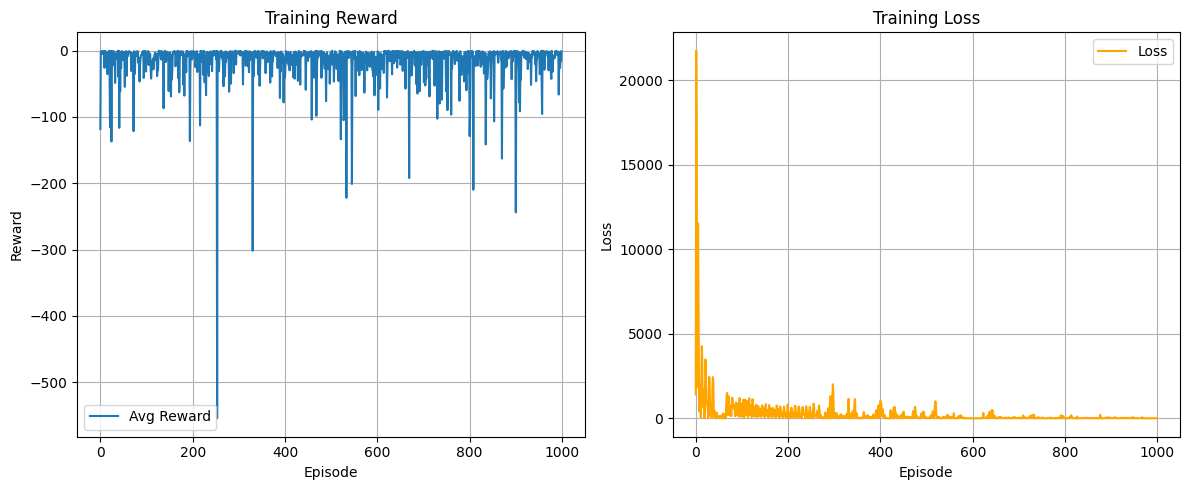

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reward_history, label='Avg Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Reward')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_history[:], label='Loss', color='orange')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


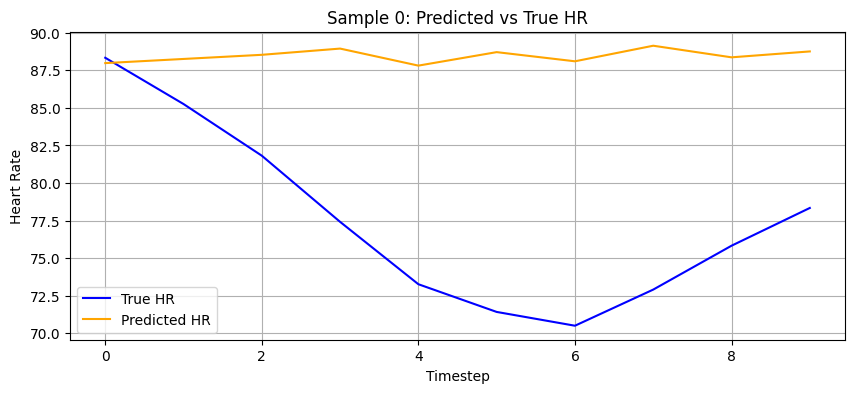

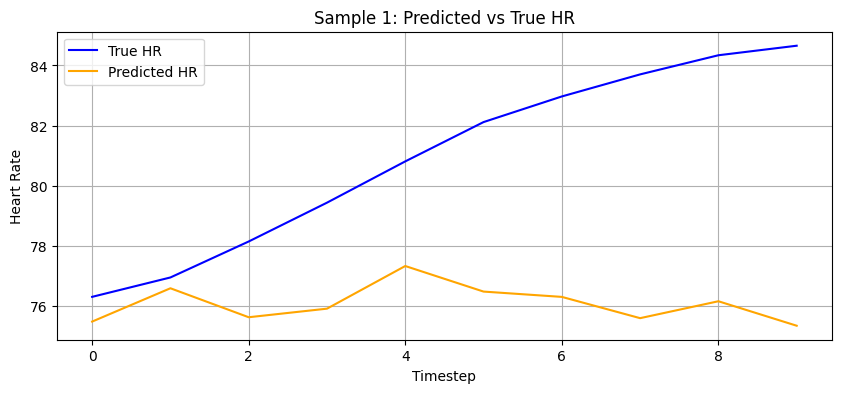

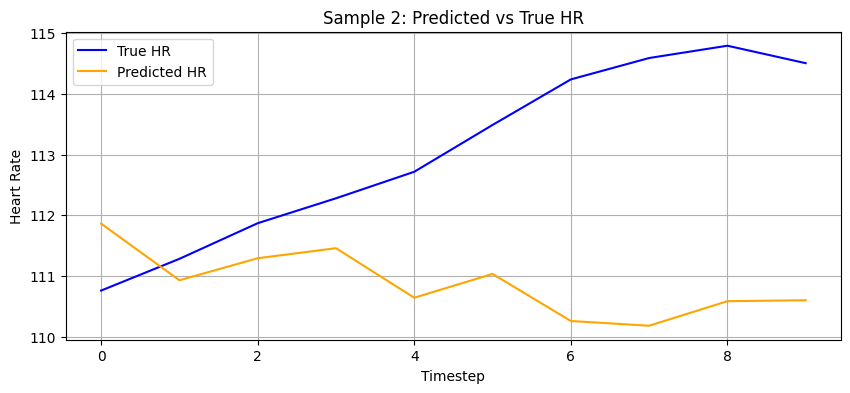

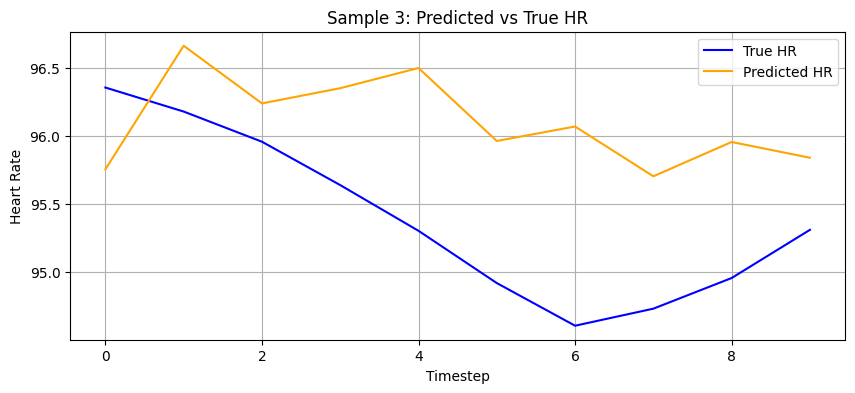

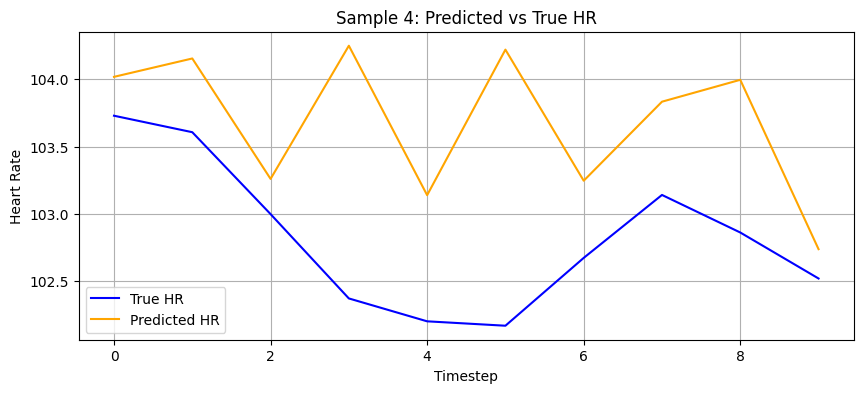

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays
pred = np.vstack(all_predicted_hr)
true = np.vstack(all_true_hr)

# Plot a few samples
for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.plot(true[i], label="True HR", color="blue")
    plt.plot(pred[i], label="Predicted HR", color="orange")
    plt.title(f"Sample {i}: Predicted vs True HR")
    plt.xlabel("Timestep")
    plt.ylabel("Heart Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
len(pred)

32000

In [8]:
pred.shape

(32000, 10)

In [9]:
for j in range(3):
    print(true[15000,j],pred[15000,j])

123.822044 123.33434
124.60451 123.68115
125.24703 124.012184


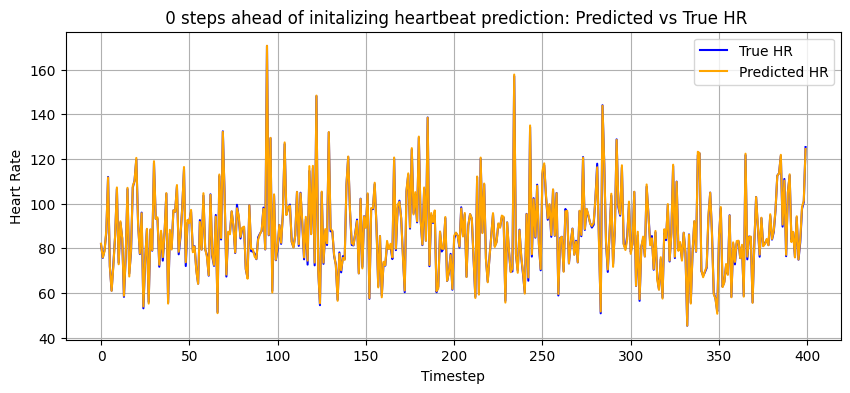

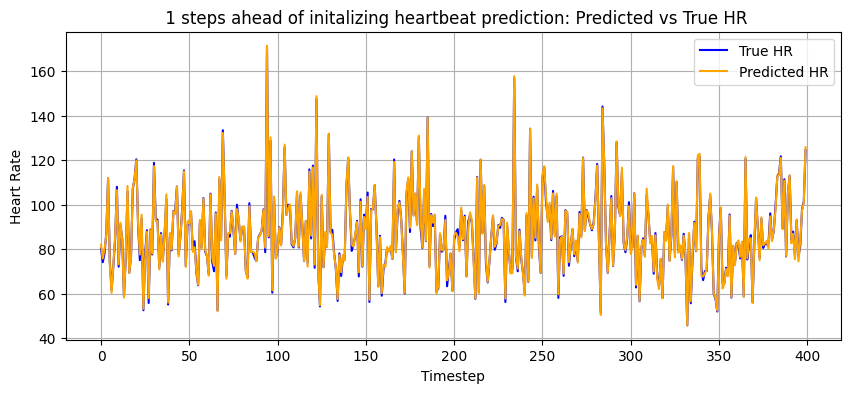

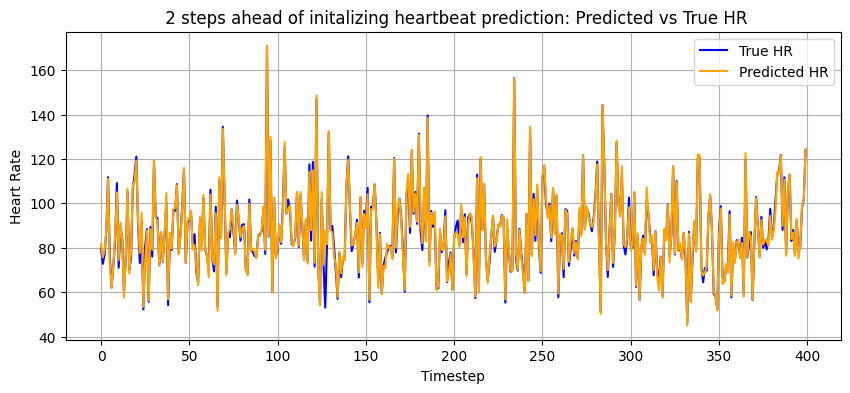

In [10]:
for j in range(3):
    plt.figure(figsize=(10, 4))
    plt.plot(true[8000:8400,j], label="True HR", color="blue")
    plt.plot(pred[8000:8400,j], label="Predicted HR", color="orange")
    plt.title(f" {j} steps ahead of initalizing heartbeat prediction: Predicted vs True HR")
    plt.xlabel("Timestep")
    plt.ylabel("Heart Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
true.shape

(32000, 10)

Test Avg Reward: -13.8726
Test Avg MSE: 3.0054
Test std MSE: 2.2000


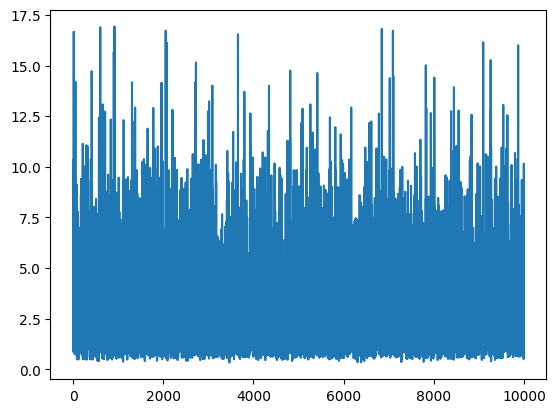

In [12]:
test_env = HRPredictionEnv(test_dataset)
test_rewards = []
test_errors = []

for _ in range(10000):  # 100 test episodes
    obs, _ = test_env.reset()
    flat_obs = np.concatenate([obs["signals"].flatten(), obs["traits"].flatten()])
    action, _ = agent.select_action(flat_obs)
    _, reward, _, _, info = test_env.step(action)

    test_rewards.append(reward)
    test_errors.append(info["prediction_error"]**0.5)
    
print(f"Test Avg Reward: {np.mean(test_rewards):.4f}")
print(f"Test Avg MSE: {np.mean(test_errors):.4f}")
print(f"Test std MSE: {np.std(test_errors):.4f}")

plt.plot(test_errors)

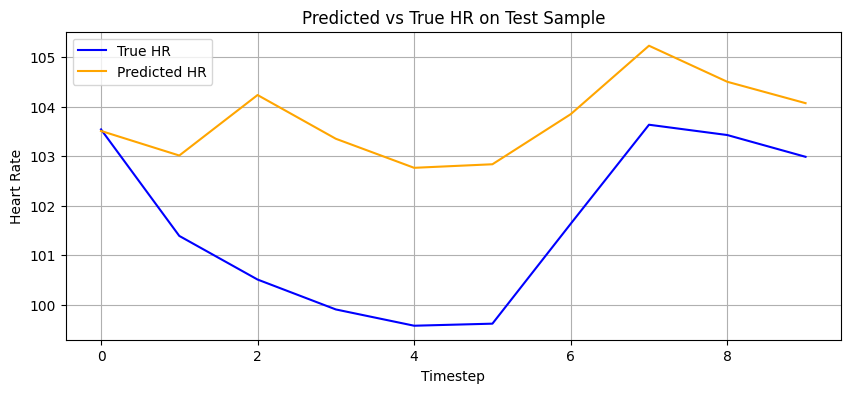

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(info["true_hr"], label="True HR", color="blue")
plt.plot(info["predicted_hr"] , label="Predicted HR", color="orange")  # one flat line
plt.title("Predicted vs True HR on Test Sample")
plt.xlabel("Timestep")
plt.ylabel("Heart Rate")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import numpy as np

past_signals = []
true_hrs = []
pred_hrs = []

for _ in range(100):  # number of test samples to animate
    obs, _ = test_env.reset()
    flat_obs = np.concatenate([obs['signals'].flatten(), obs['traits'].flatten()])
    action, _ = agent.select_action(flat_obs)
    
    _, _, _, _, info = test_env.step(action)

    # Store the last 60s of HR and the next 3s (pred vs true)
    past_signals.append(obs['signals'][0])  # HR channel only
    true_hrs.append(info['true_hr'])
    pred_hrs.append(info['predicted_hr'])


In [15]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))

line_past, = ax.plot([], [], label="Past HR (60s)", color='blue')
line_true, = ax.plot([], [], 'go-', label="True HR (3s)")
line_pred, = ax.plot([], [], 'ro--', label="Predicted HR (3s)")

ax.set_ylim(30, 180)  # adjust based on your data
ax.set_xlim(0, 70)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Heart Rate (BPM)")
ax.legend()

def update(frame):
    past = past_signals[frame]
    true = true_hrs[frame]
    pred = pred_hrs[frame]

    x_past = np.arange(60)
    x_future = np.arange(60, 70)

    line_past.set_data(x_past, past)
    line_true.set_data(x_future, true)
    line_pred.set_data(x_future, pred)

    return line_past, line_true, line_pred

ani = FuncAnimation(fig, update, frames=len(past_signals), interval=800, blit=True)
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())